# Imports

In [1]:
import tensorflow_addons as tfa
from utils import *
import tensorflow as tf
from tensorflow import keras
import pickle
from datetime import datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import keras_tuner
import warnings
import calendar
import collections.abc
collections.Iterable = collections.abc.Iterable
warnings.filterwarnings("ignore")


2023-04-21 19:37:20.243901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 19:37:20.903486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-21 19:37:20.903541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-21 19:37:20.903548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-20 23:29:23.638133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 23:29:23.690855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 23:29:23.691021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
%load_ext tensorboard


# Experiments

## Deeper Model

In [4]:
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [5]:
def model1(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(50, return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 00m 21s]
val_loss: 10.244626998901367

Best val_loss So Far: 7.042524337768555
Total elapsed time: 00h 09m 38s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 2s 116ms/step


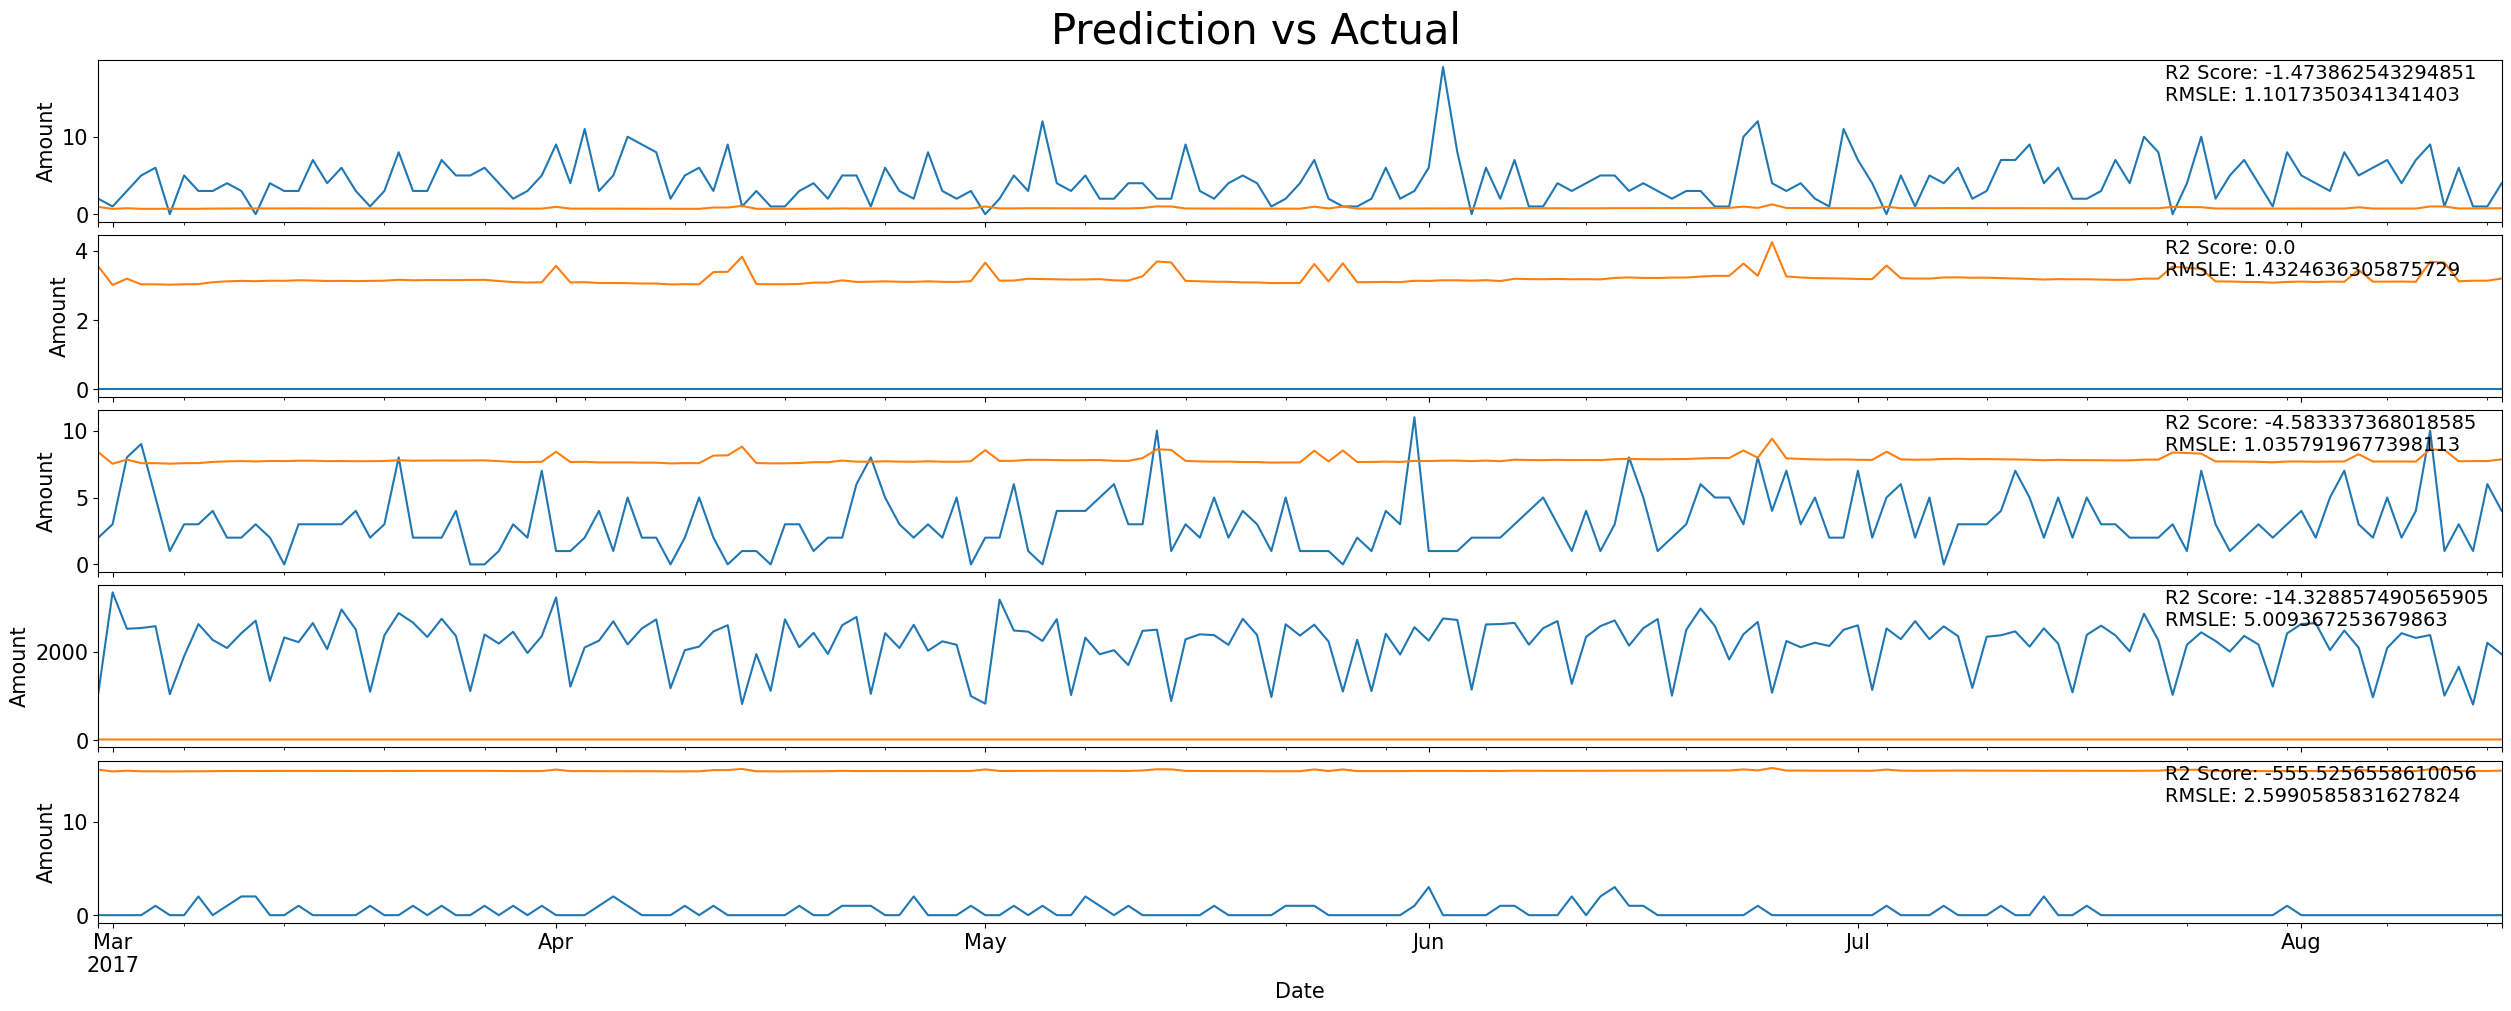

R2 Score                      -206.440911
Root Mean Squared Log Error      2.275546
dtype: float64


In [6]:
experiment(X_train, X_test, y_train, y_test, X_test_copy,
           X_test_index, model1, 'model1', '6 layers of 50 LSTM cells')


## Wider Deep Network

In [7]:
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [17]:
def model2(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(200, return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 00m 33s]
val_loss: 7.189244747161865

Best val_loss So Far: 2.172891139984131
Total elapsed time: 00h 13m 50s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 2s 206ms/step


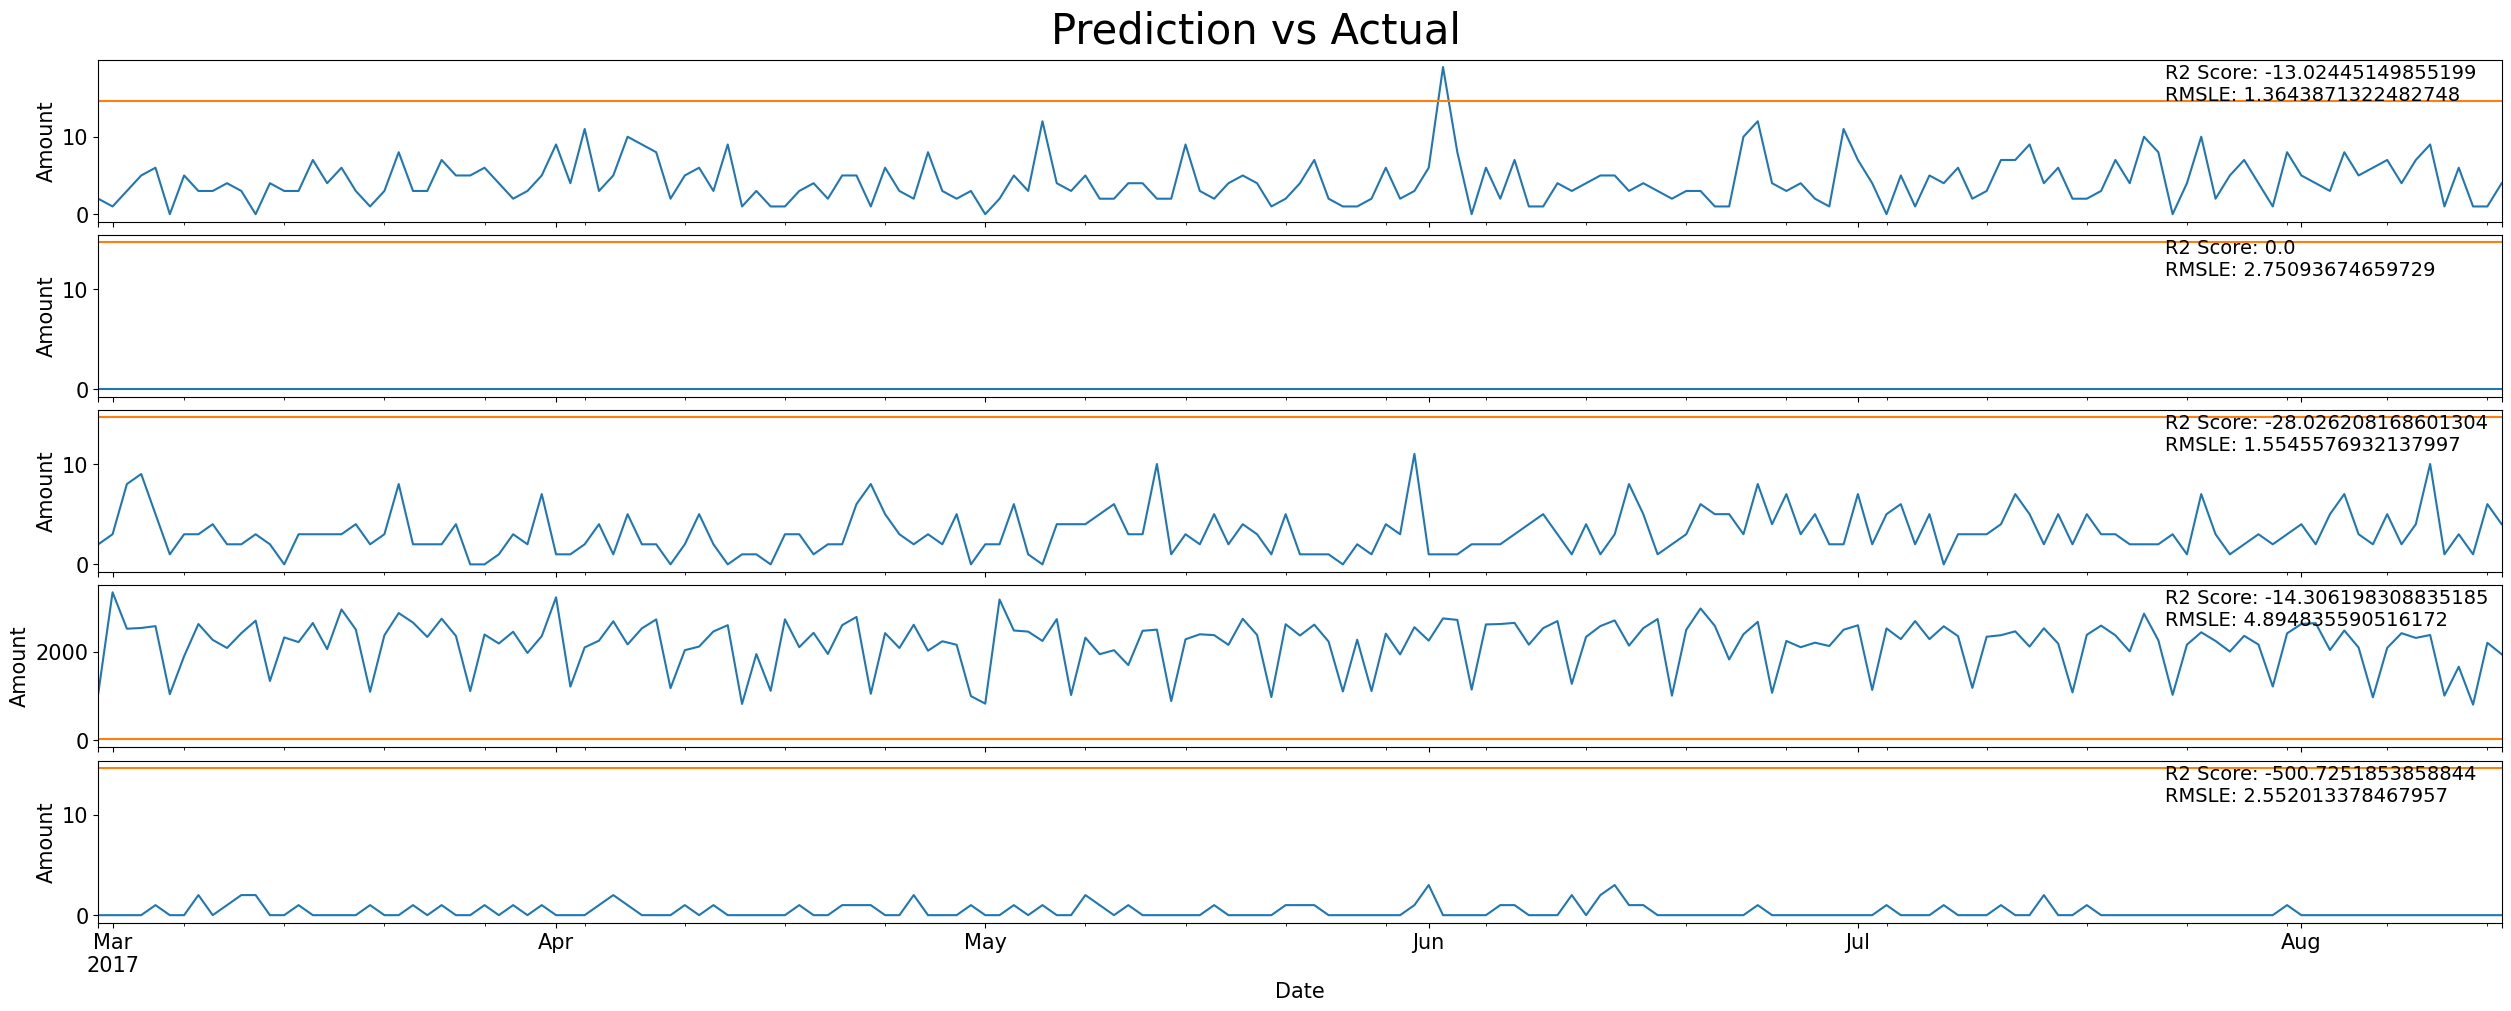

R2 Score                      -166.116058
Root Mean Squared Log Error      2.292427
dtype: float64


In [9]:
experiment(X_train, X_test, y_train, y_test, X_test_copy,
           X_test_index, model2, 'model2', '6 layers of 200 LSTM cells')


## Implementing Layer Normalization

In [3]:
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [5]:
def model3(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(
            50), return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 24 Complete [00h 03m 06s]
val_loss: 7.49183464050293

Best val_loss So Far: 6.256971836090088
Total elapsed time: 01h 11m 16s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 2s 349ms/step


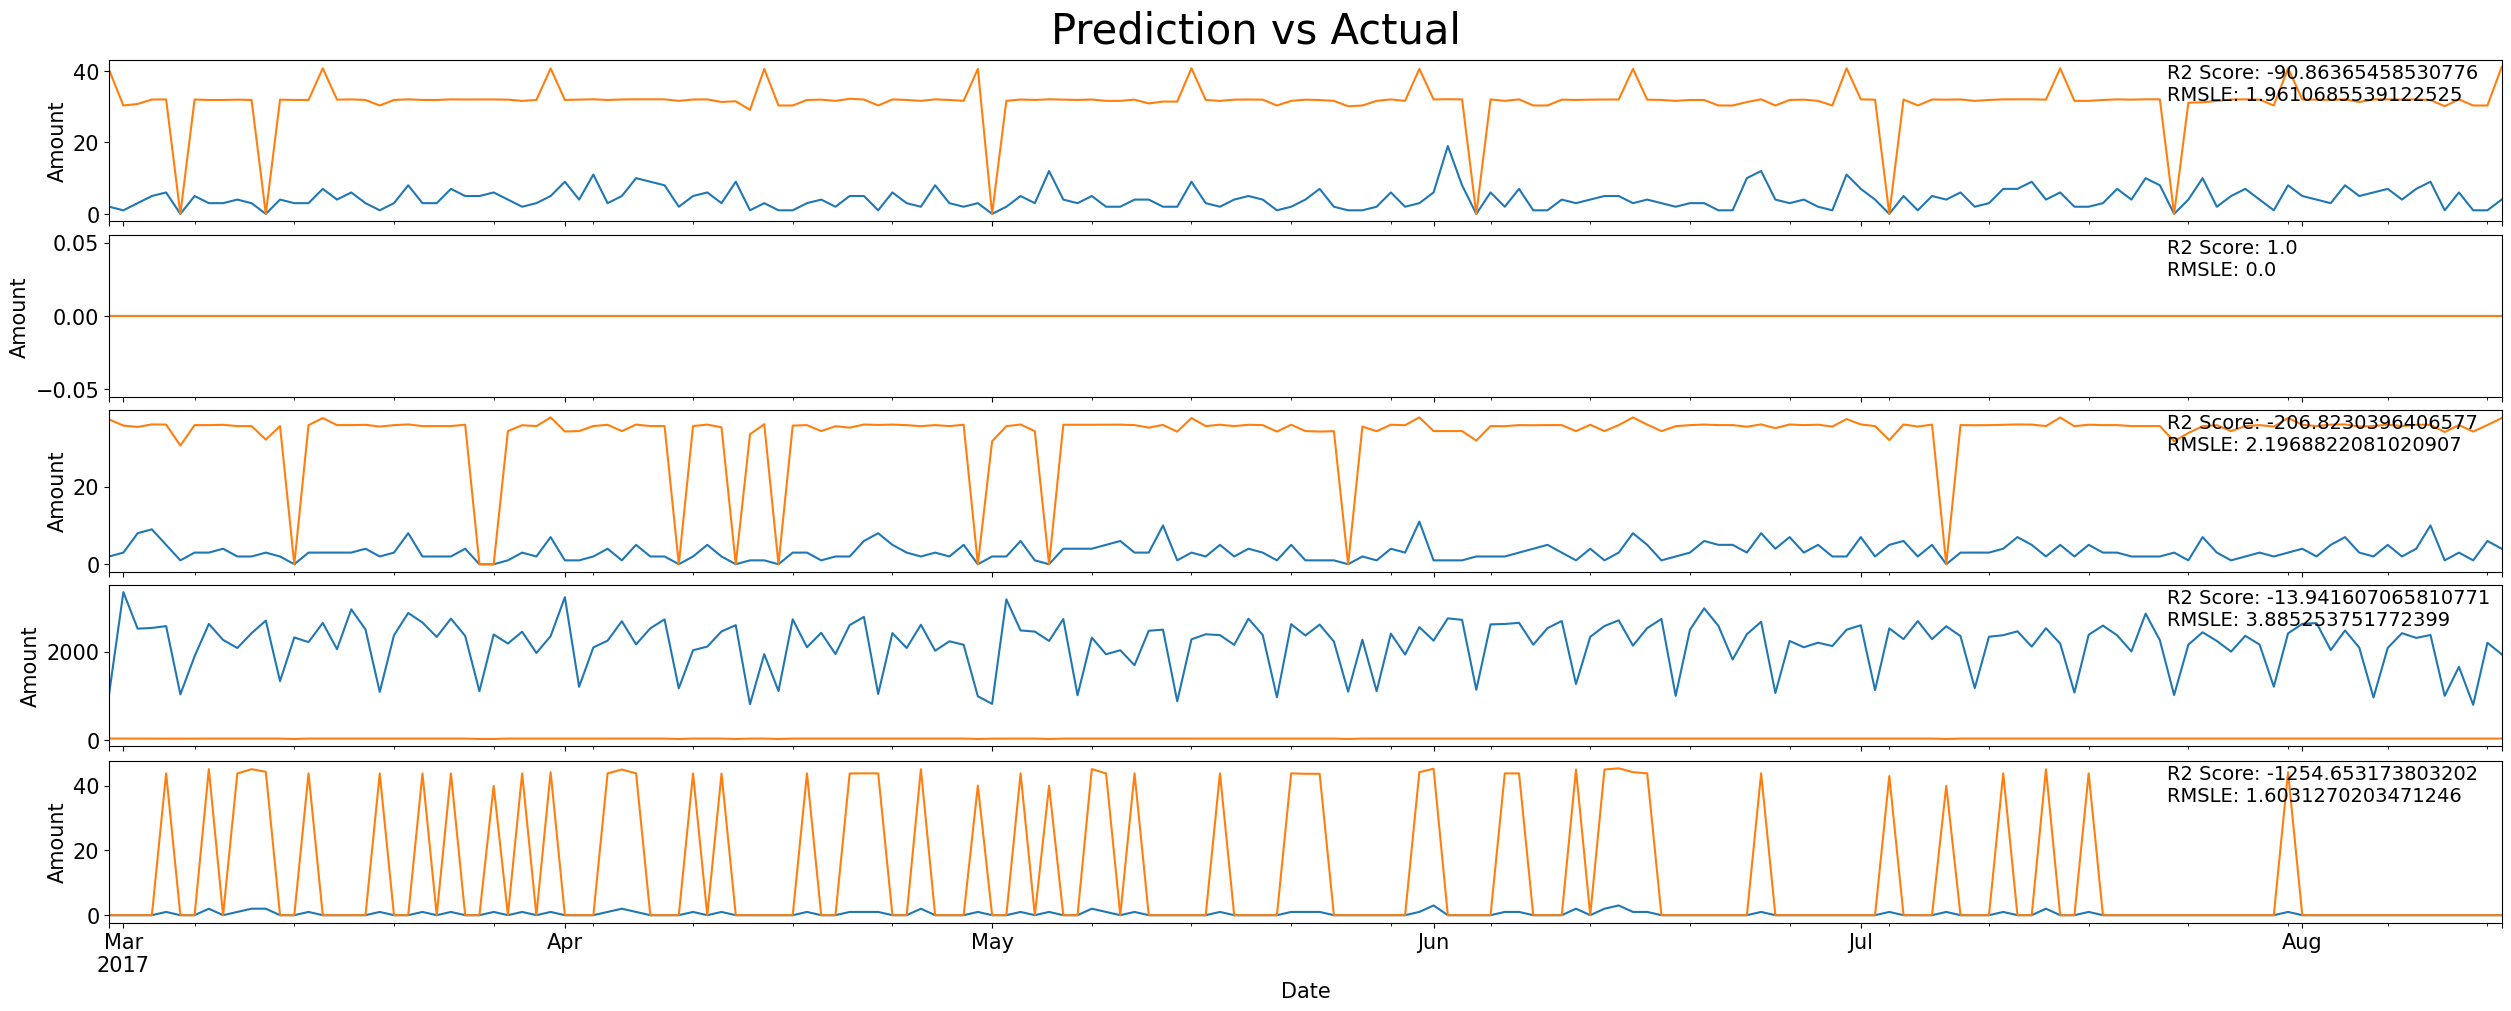

R2 Score                      -155.132212
Root Mean Squared Log Error      1.802875
dtype: float64


In [6]:
experiment(X_train, X_test, y_train, y_test, X_test_copy, X_test_index,
           model3, 'model3', 'single layer of 100 layernormLSTMcells')


## Wide Network

In [4]:
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [5]:
def model4(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1], return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 01m 46s]
val_loss: 2.5854461193084717

Best val_loss So Far: 1.4551939964294434
Total elapsed time: 00h 46m 33s
INFO:tensorflow:Oracle triggered exit


2023-04-19 01:57:58.819169: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3138109440 exceeds 10% of free system memory.
2023-04-19 01:59:16.747391: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3138109440 exceeds 10% of free system memory.
2023-04-19 02:00:34.823159: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3138109440 exceeds 10% of free system memory.
2023-04-19 02:01:52.931196: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3138109440 exceeds 10% of free system memory.
2023-04-19 02:03:11.121877: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3138109440 exceeds 10% of free system memory.


6/6 [==============================] - 5s 729ms/step


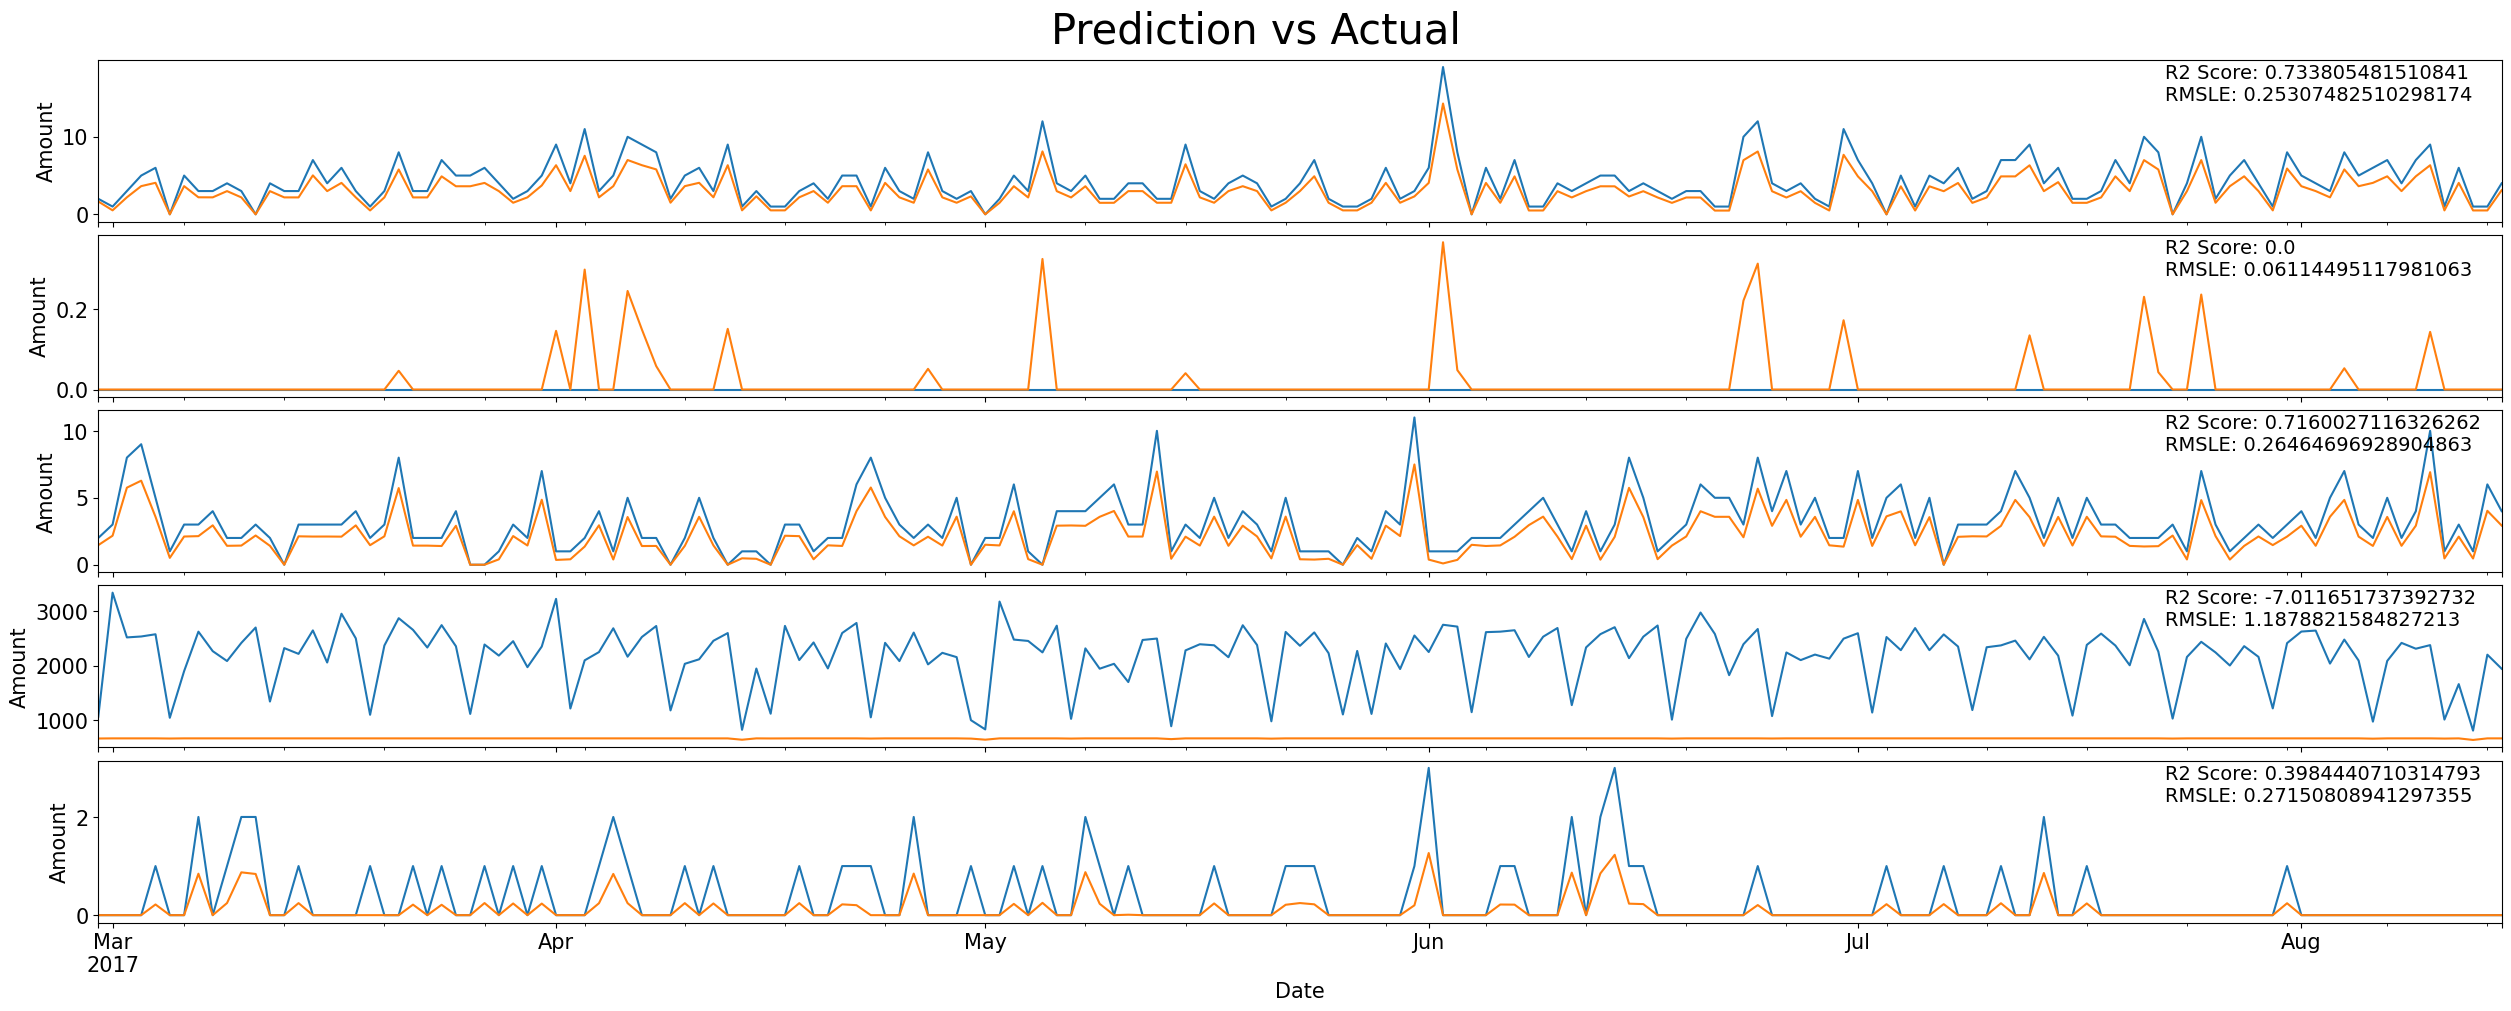

R2 Score                      -0.363889
Root Mean Squared Log Error    0.341014
dtype: float64


In [6]:
experiment(X_train, X_test, y_train, y_test, X_test_copy,
           X_test_index, model4, 'model4', 'Single wide Layer of one cell per series')


## Complex Network with Multiple Inputs

In [3]:
train.var().describe()

count    1.782000e+03
mean     2.899269e+05
std      1.597741e+06
min      0.000000e+00
25%      1.278374e+01
50%      3.950080e+02
75%      1.744068e+04
max      3.103424e+07
dtype: float64

In [4]:
low_var = [train.var().index[i] for i in range(len(train.var())) if train.var()[i]<395]
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [5]:
X1 = exog
X2 = train[low_var]
X3 = train.drop(low_var, axis=1)
X1_train, X1_test = train_test_split(X1, test_size=0.10, random_state=5, shuffle=False)
X2_train, X2_test = train_test_split(X2, test_size=0.10, random_state=5, shuffle=False)
X3_train, X3_test = train_test_split(X3, test_size=0.10, random_state=5, shuffle=False)
train_sets = [X1_train, X2_train, X3_train]
test_sets = [X1_test, X2_test, X3_test]
for j in [train_sets, test_sets]:
    for i in range(len(j)):
        j[i] = j[i].values.reshape(j[i].shape[0], j[i].shape[1], 1)

In [9]:
def model5(hp):
    input_1 = keras.layers.Input(shape=[train_sets[0].shape[1], train_sets[0].shape[2]])
    input_2 = keras.layers.Input(shape=[train_sets[1].shape[1], train_sets[1].shape[2]])
    input_3 = keras.layers.Input(shape=[train_sets[2].shape[1], train_sets[2].shape[2]])
    exog_hidden_1 = keras.layers.LSTM(10)(input_1)
    low_var_hidden_1 = keras.layers.LSTM(train_sets[1].shape[1]//4)(input_2)
    high_var_hidden_1 = keras.layers.LSTM(train_sets[2].shape[1]//4, return_sequences=True)(input_3)
    high_var_hidden_2 = keras.layers.LSTM(train_sets[2].shape[1]//4, return_sequences=True)(high_var_hidden_1)
    high_var_hidden_3 = keras.layers.LSTM(train_sets[2].shape[1]//4)(high_var_hidden_2)
    concat = keras.layers.concatenate([exog_hidden_1, low_var_hidden_1, high_var_hidden_3])
    output = keras.layers.Dense(X_train.shape[1], activation='relu')(concat)
    dummy_model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 00m 18s]
val_loss: 10.414190292358398

Best val_loss So Far: 4.189591884613037
Total elapsed time: 00h 07m 12s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 1s 71ms/step


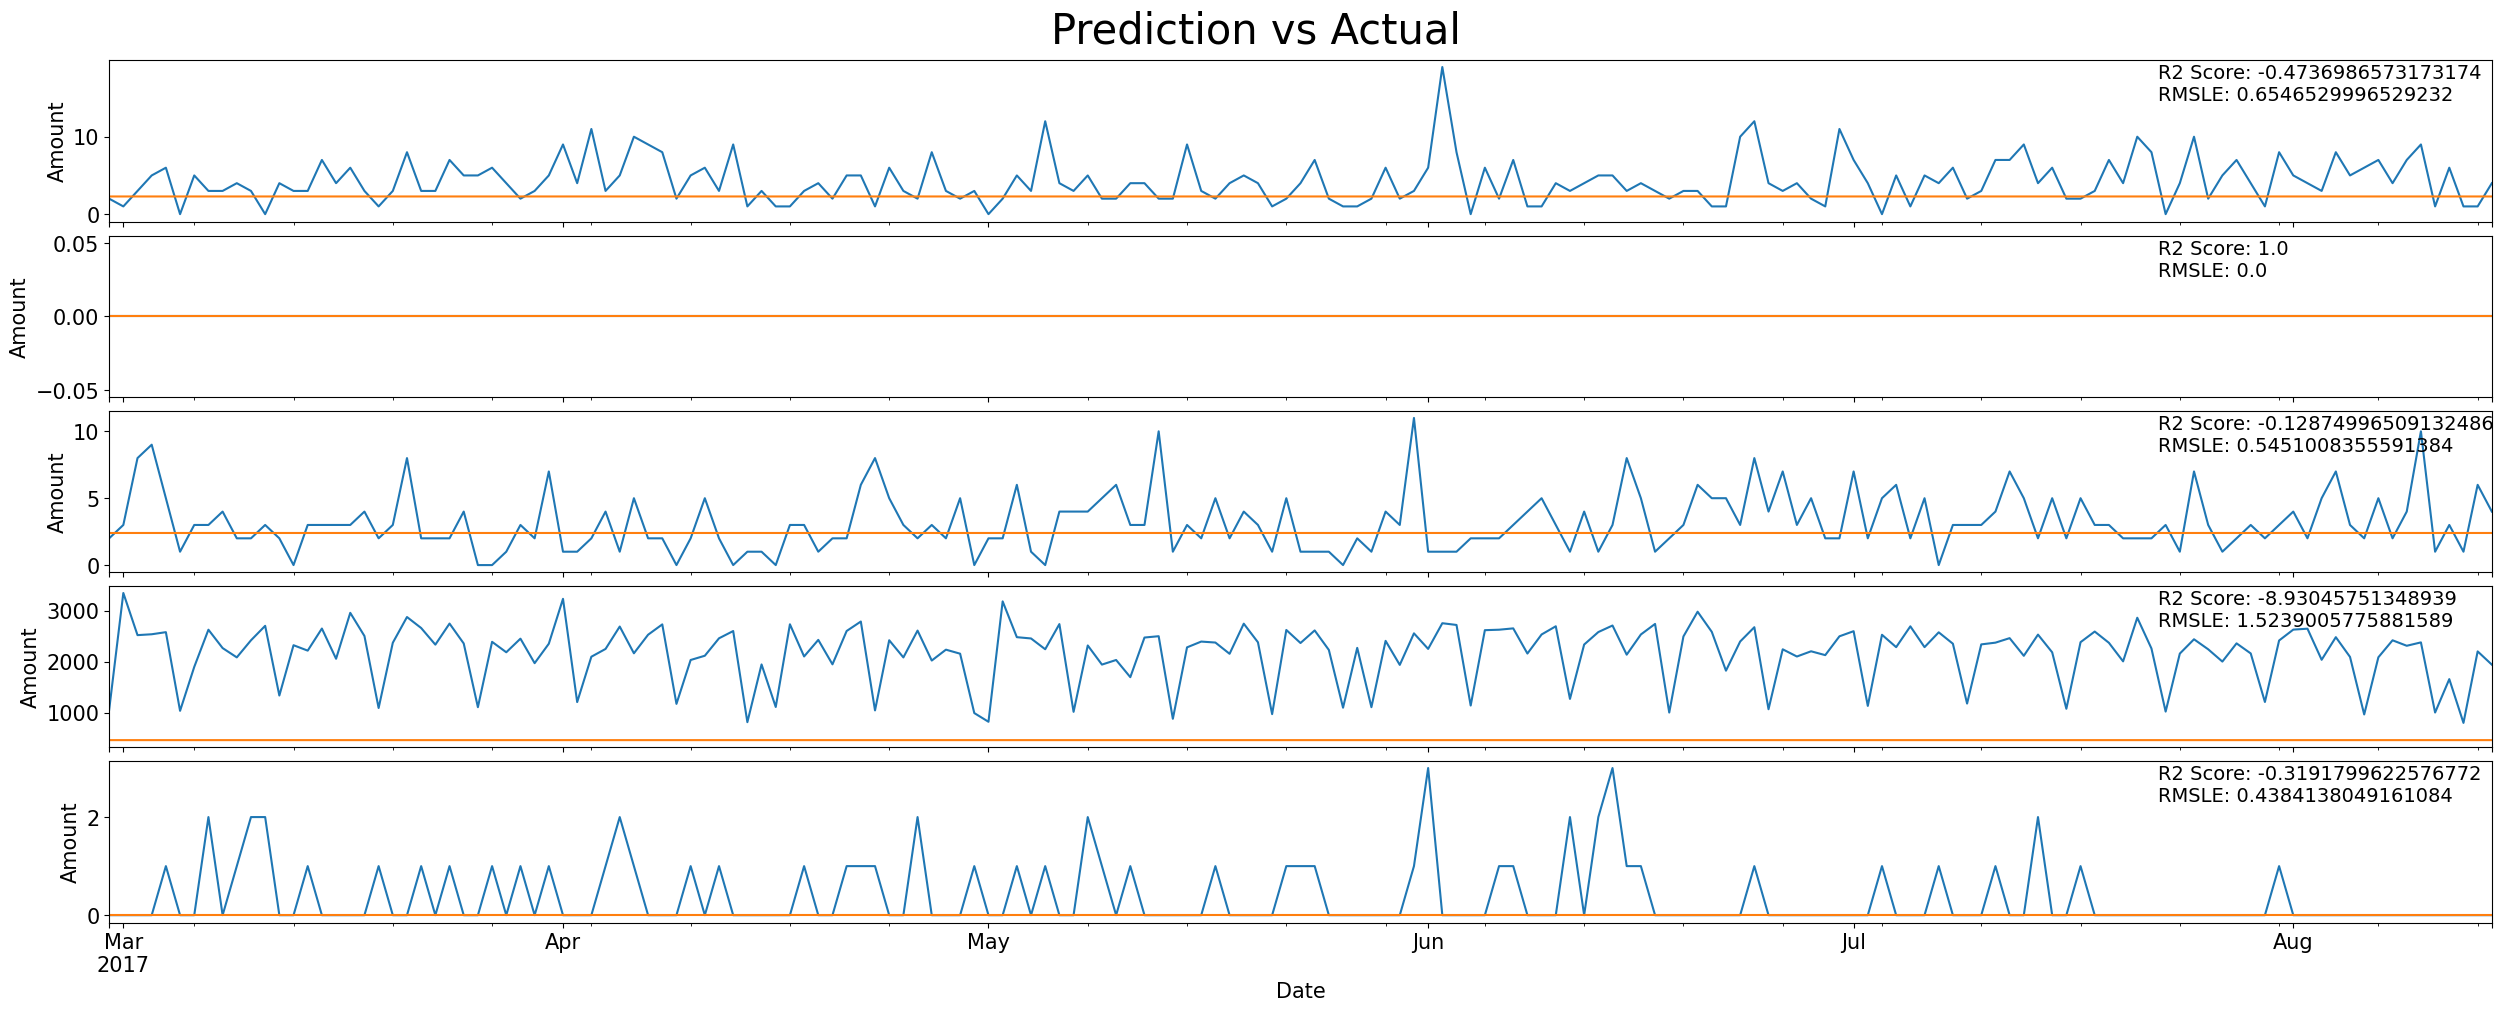

R2 Score                      -3.847017
Root Mean Squared Log Error    1.809955
dtype: float64


In [10]:
experiment(train_sets, test_sets, y_train, y_test, X_test_copy, X_test_index, model5, 'model5', 'complex LSTM ')

## Double Layer Wide Network

In [10]:
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [11]:
def model6(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1]//2, return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.LSTM(3,return_sequences=True),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 24 Complete [00h 00m 41s]
val_loss: 8.452741622924805

Best val_loss So Far: 6.618439197540283
Total elapsed time: 00h 16m 20s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 2s 269ms/step


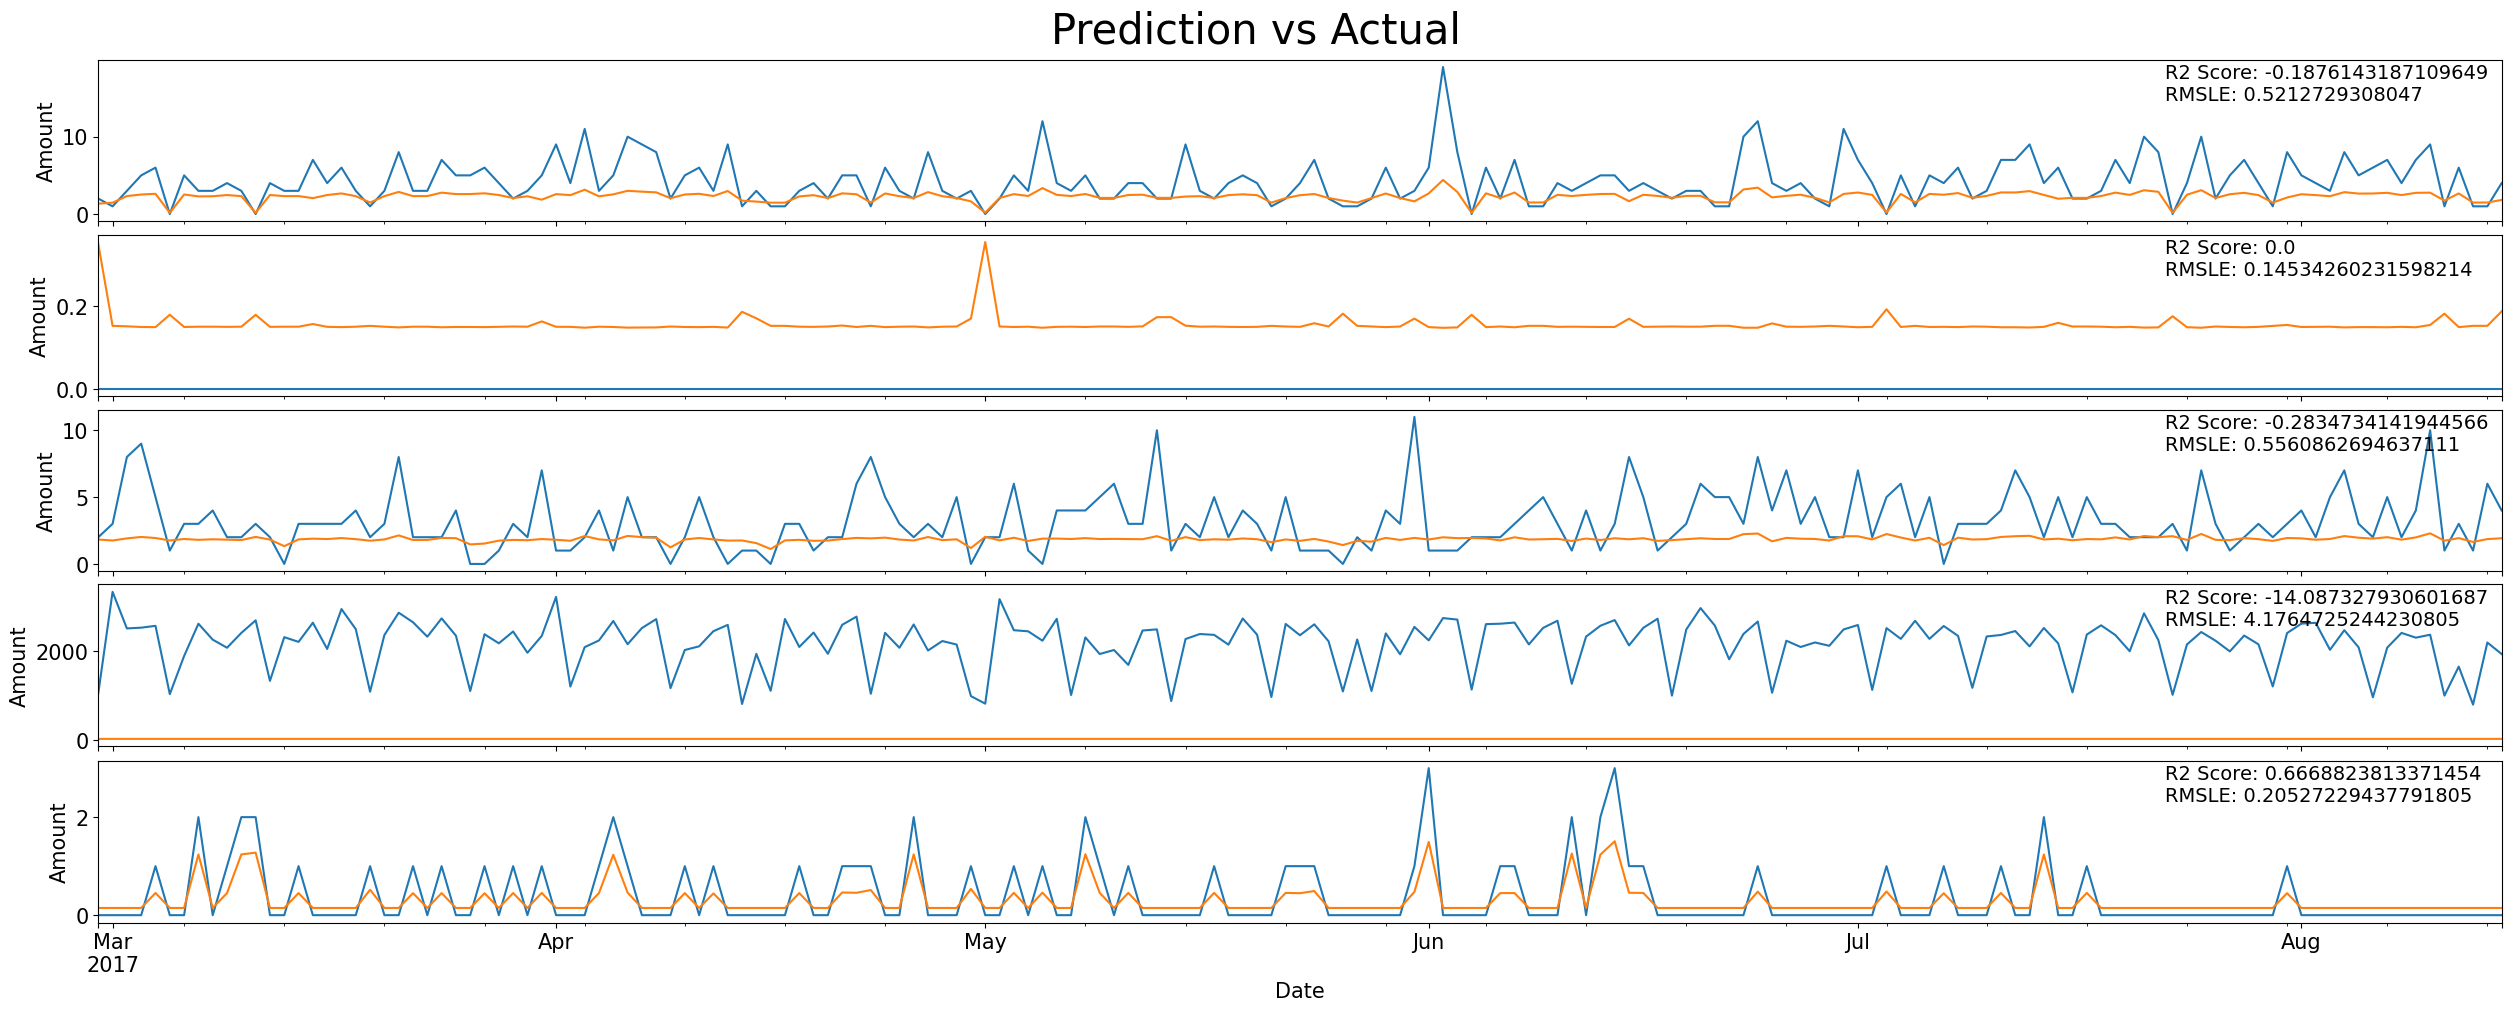

R2 Score                      -4.315261
Root Mean Squared Log Error    1.377440
dtype: float64


In [12]:
experiment(X_train, X_test, y_train, y_test, X_test_copy,
           X_test_index, model6, 'model6', 'Double layer wide network')


## Implementing GRU

In [13]:
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [14]:
def model7(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.GRU(X_train.shape[1], return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 01m 21s]
val_loss: 11.809213638305664

Best val_loss So Far: 1.2382336854934692
Total elapsed time: 00h 39m 42s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 4s 590ms/step


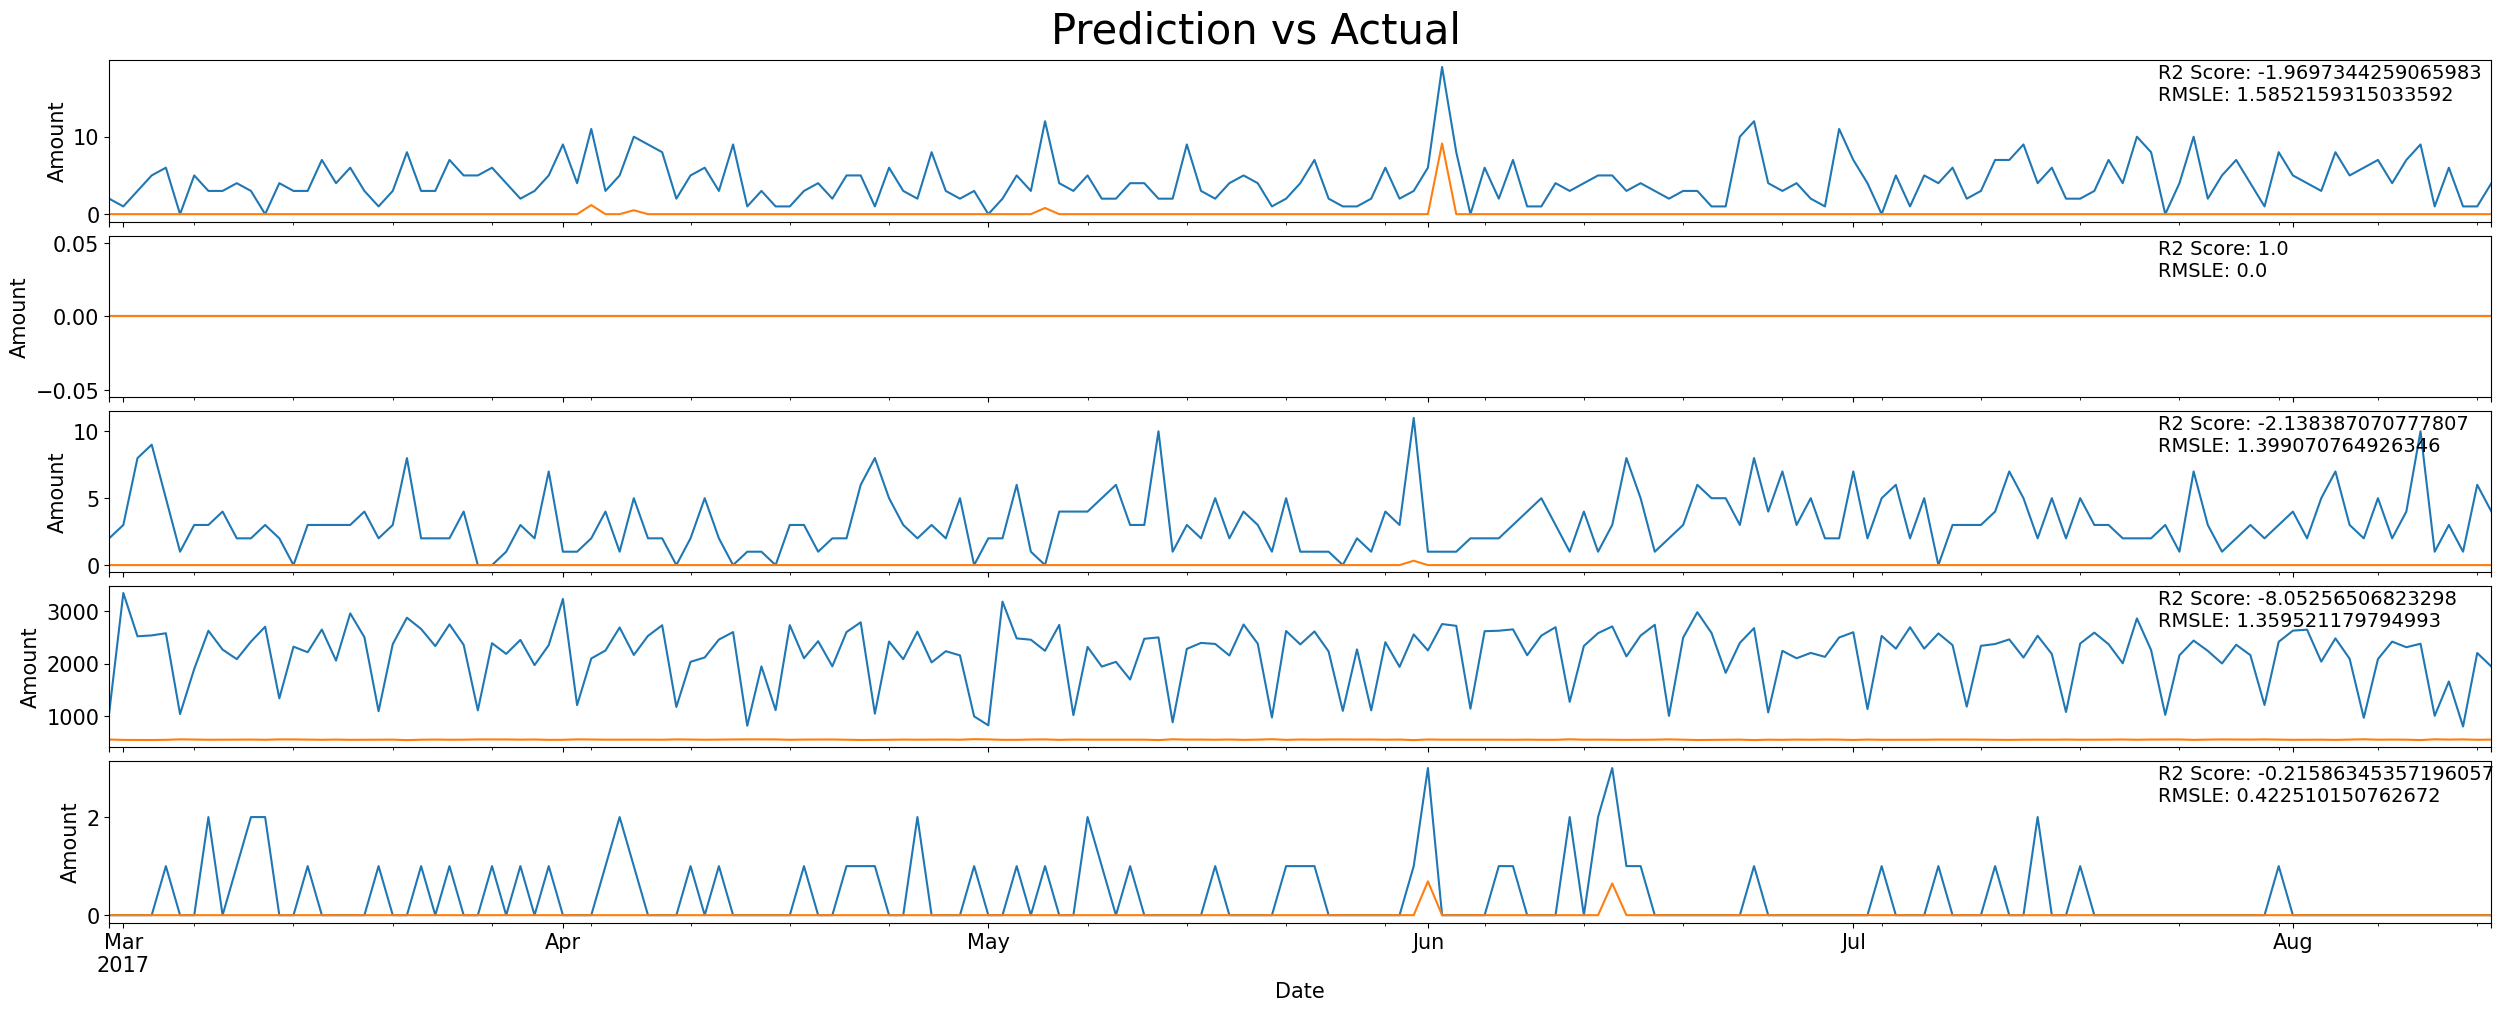

R2 Score                      -0.876060
Root Mean Squared Log Error    0.416985
dtype: float64


In [15]:
experiment(X_train, X_test, y_train, y_test, X_test_copy,
           X_test_index, model7, 'model7', 'Single layer GRU wide network')


## Complex GRU Network with Multiple Inputs

In [16]:
low_var = [train.var().index[i] for i in range(len(train.var())) if train.var()[i]<395]
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [17]:
X1 = exog
X2 = train[low_var]
X3 = train.drop(low_var, axis=1)
X1_train, X1_test = train_test_split(X1, test_size=0.10, random_state=5, shuffle=False)
X2_train, X2_test = train_test_split(X2, test_size=0.10, random_state=5, shuffle=False)
X3_train, X3_test = train_test_split(X3, test_size=0.10, random_state=5, shuffle=False)
train_sets = [X1_train, X2_train, X3_train]
test_sets = [X1_test, X2_test, X3_test]
for j in [train_sets, test_sets]:
    for i in range(len(j)):
        j[i] = j[i].values.reshape(j[i].shape[0], j[i].shape[1], 1)

In [18]:
def model8(hp):
    input_1 = keras.layers.Input(shape=[train_sets[0].shape[1], train_sets[0].shape[2]])
    input_2 = keras.layers.Input(shape=[train_sets[1].shape[1], train_sets[1].shape[2]])
    input_3 = keras.layers.Input(shape=[train_sets[2].shape[1], train_sets[2].shape[2]])
    exog_hidden_1 = keras.layers.GRU(10)(input_1)
    low_var_hidden_1 = keras.layers.GRU(train_sets[1].shape[1]//4)(input_2)
    high_var_hidden_1 = keras.layers.GRU(train_sets[2].shape[1]//4, return_sequences=True)(input_3)
    high_var_hidden_2 = keras.layers.GRU(train_sets[2].shape[1]//4, return_sequences=True)(high_var_hidden_1)
    high_var_hidden_3 = keras.layers.GRU(train_sets[2].shape[1]//4)(high_var_hidden_2)
    concat = keras.layers.concatenate([exog_hidden_1, low_var_hidden_1, high_var_hidden_3])
    output = keras.layers.Dense(X_train.shape[1], activation='relu')(concat)
    dummy_model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 00m 15s]
val_loss: 11.414185523986816

Best val_loss So Far: 3.606187582015991
Total elapsed time: 00h 06m 39s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 1s 63ms/step


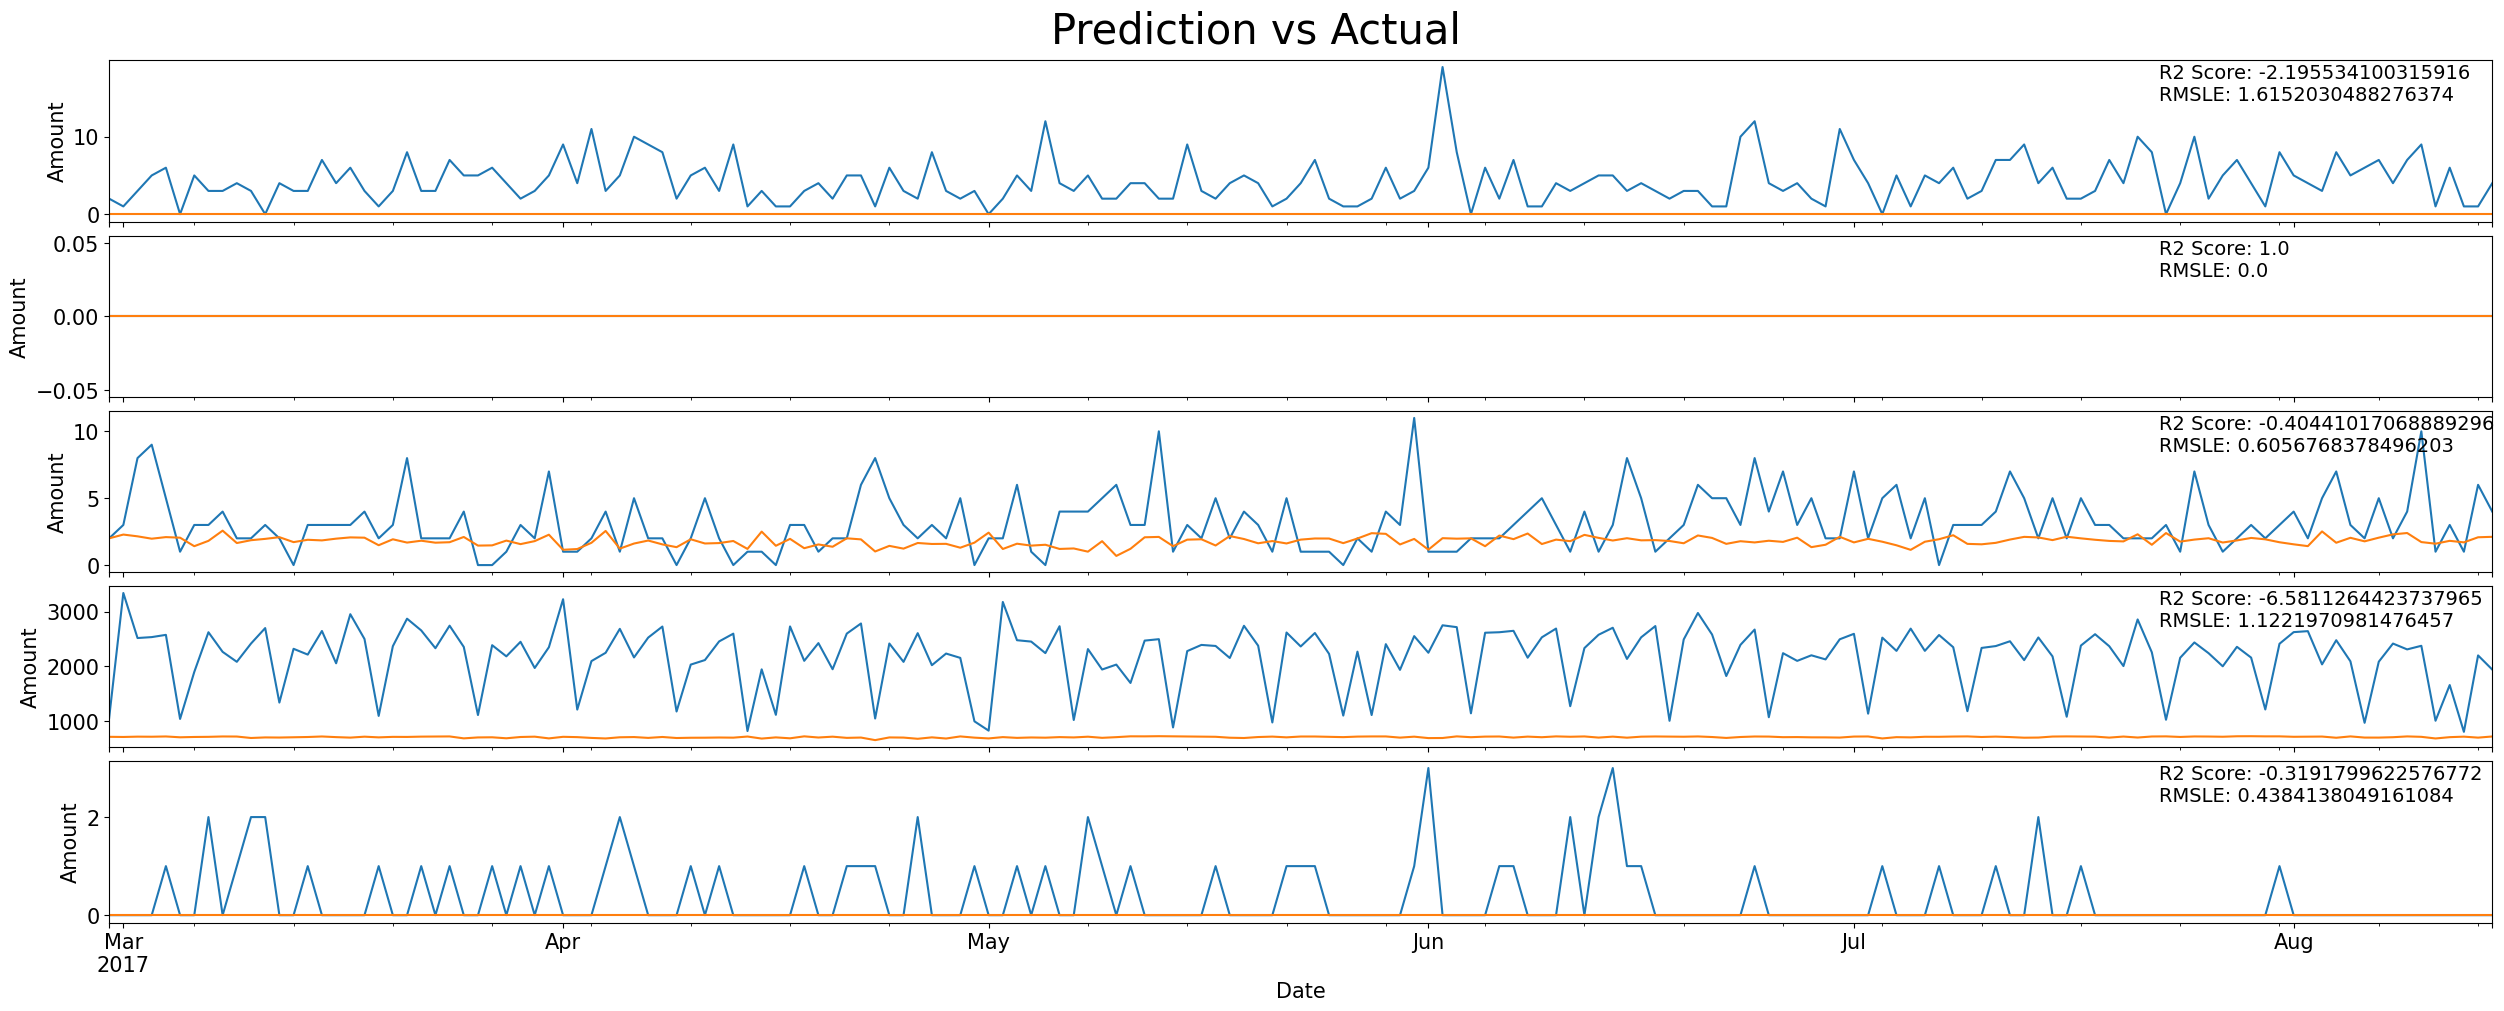

R2 Score                      -2.156276
Root Mean Squared Log Error    1.149890
dtype: float64


In [19]:
experiment(train_sets, test_sets, y_train, y_test, X_test_copy, X_test_index, model8, 'model8', 'complex GRU')

## Wide LSTM with Additional Dense Layer

In [17]:
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index = data_prep(X, Y)


(1515, 1808, 1)
(169, 1808, 1)
(1515, 1808, 1)
(169, 1808, 1)


In [18]:
def model9(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1], return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(X_train.shape[1], activation='relu'),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 01m 56s]
val_loss: 11.809211730957031

Best val_loss So Far: 0.7447757124900818
Total elapsed time: 00h 54m 25s
INFO:tensorflow:Oracle triggered exit


2023-04-20 11:18:04.016683: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3138109440 exceeds 10% of free system memory.
2023-04-20 11:18:05.006353: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 784527360 exceeds 10% of free system memory.
2023-04-20 11:19:40.768248: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3138109440 exceeds 10% of free system memory.
2023-04-20 11:19:41.526246: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 784527360 exceeds 10% of free system memory.
2023-04-20 11:21:16.567886: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3138109440 exceeds 10% of free system memory.


6/6 [==============================] - 5s 867ms/step


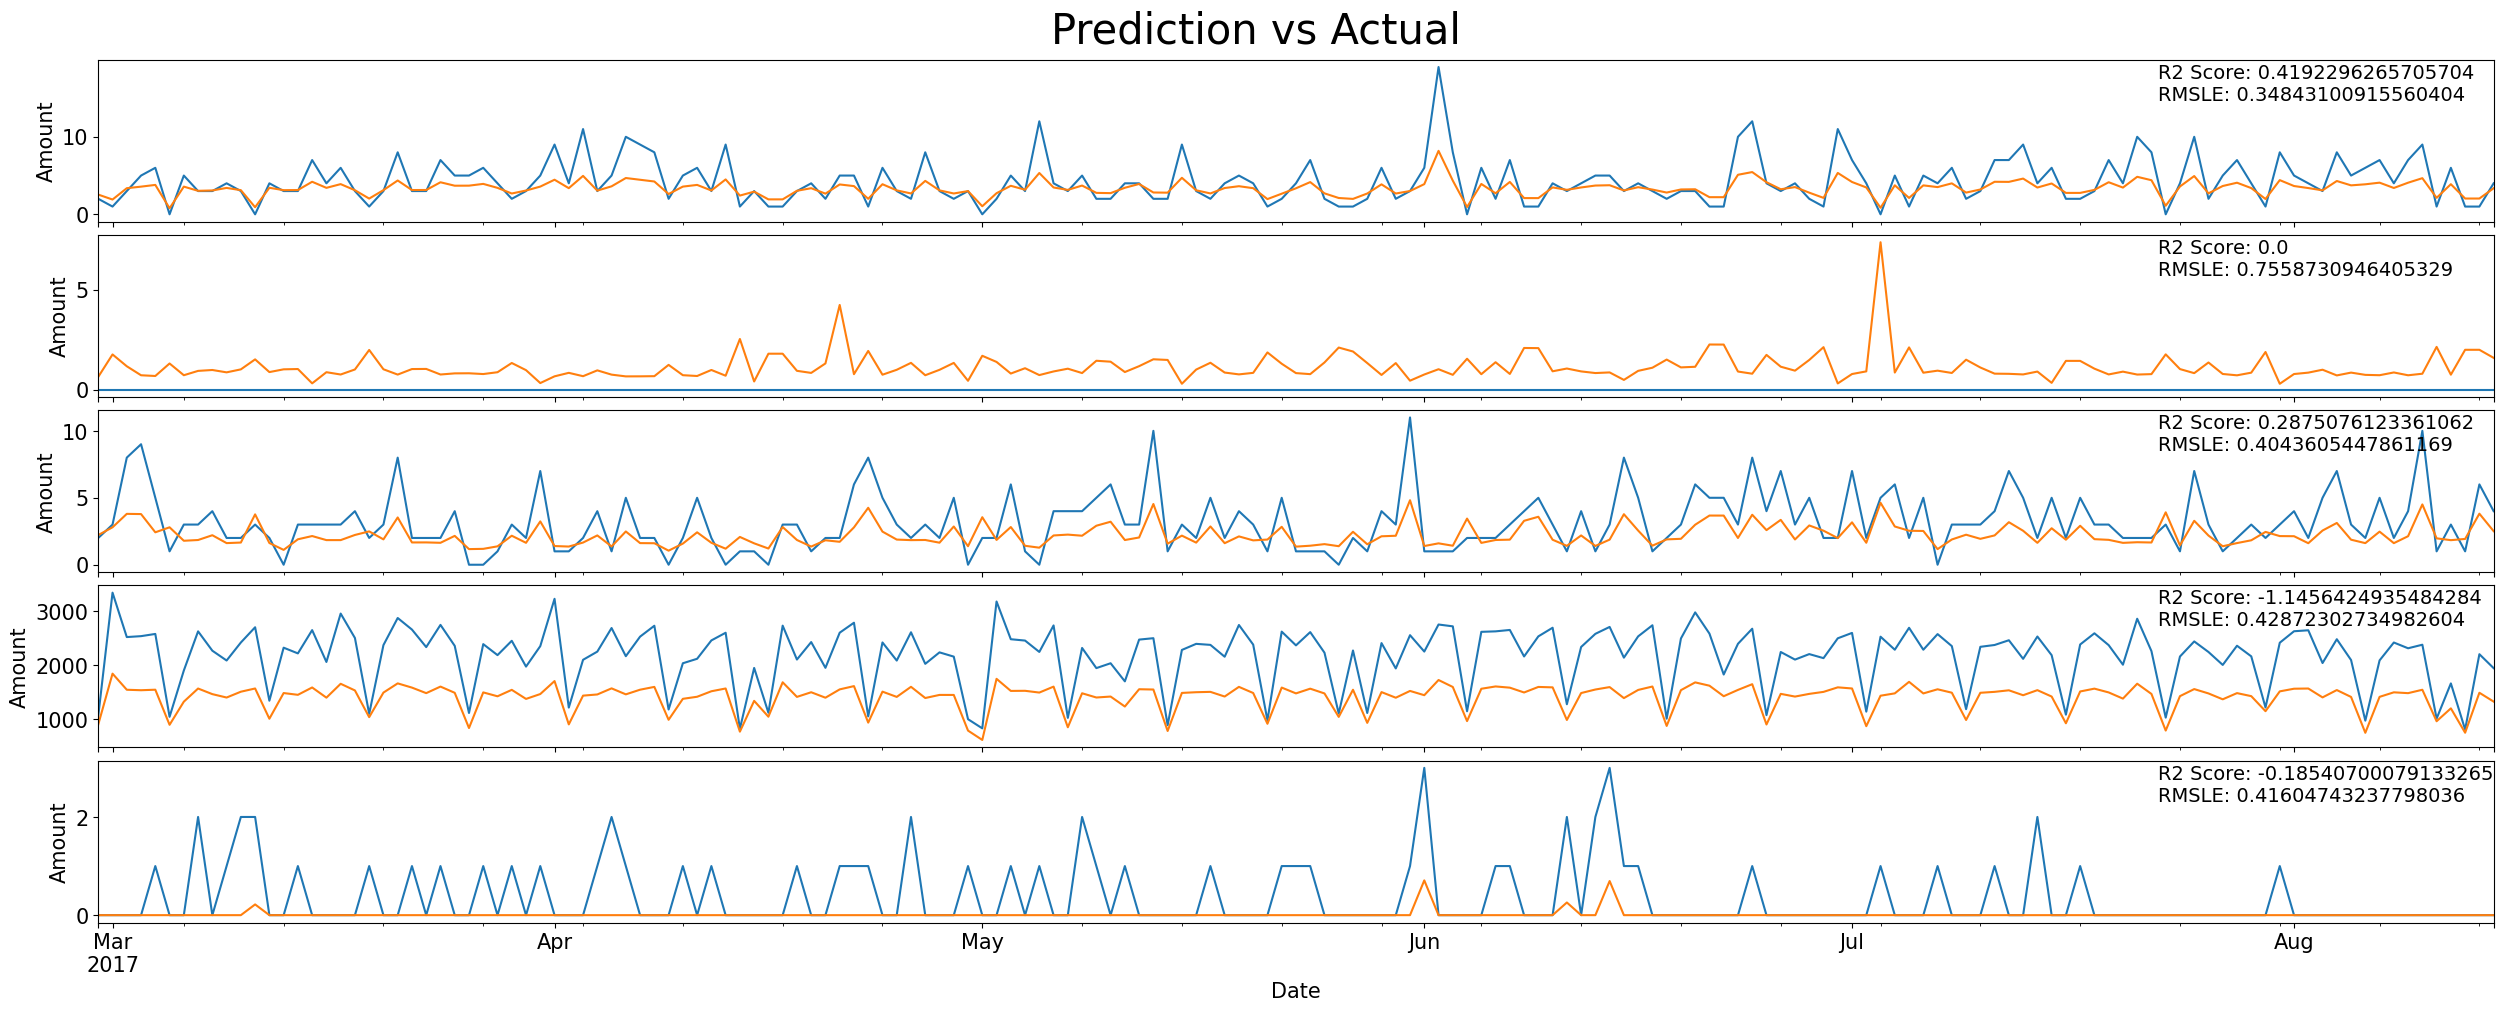

R2 Score                       0.075648
Root Mean Squared Log Error    0.363074
dtype: float64


In [19]:
experiment(X_train, X_test, y_train, y_test, X_test_copy,
           X_test_index, model9, 'model9', 'Wide LSTM with Additional Dense Layer')


## Normalizing Only Train Data

In [2]:
X = train
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index, scaler = data_prep(X, Y, scale=True)

In [3]:
def model10(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(100, return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 24 Complete [00h 00m 05s]
val_loss: 0.019479690119624138

Best val_loss So Far: 0.005667545832693577
Total elapsed time: 00h 01m 54s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 0s 24ms/step


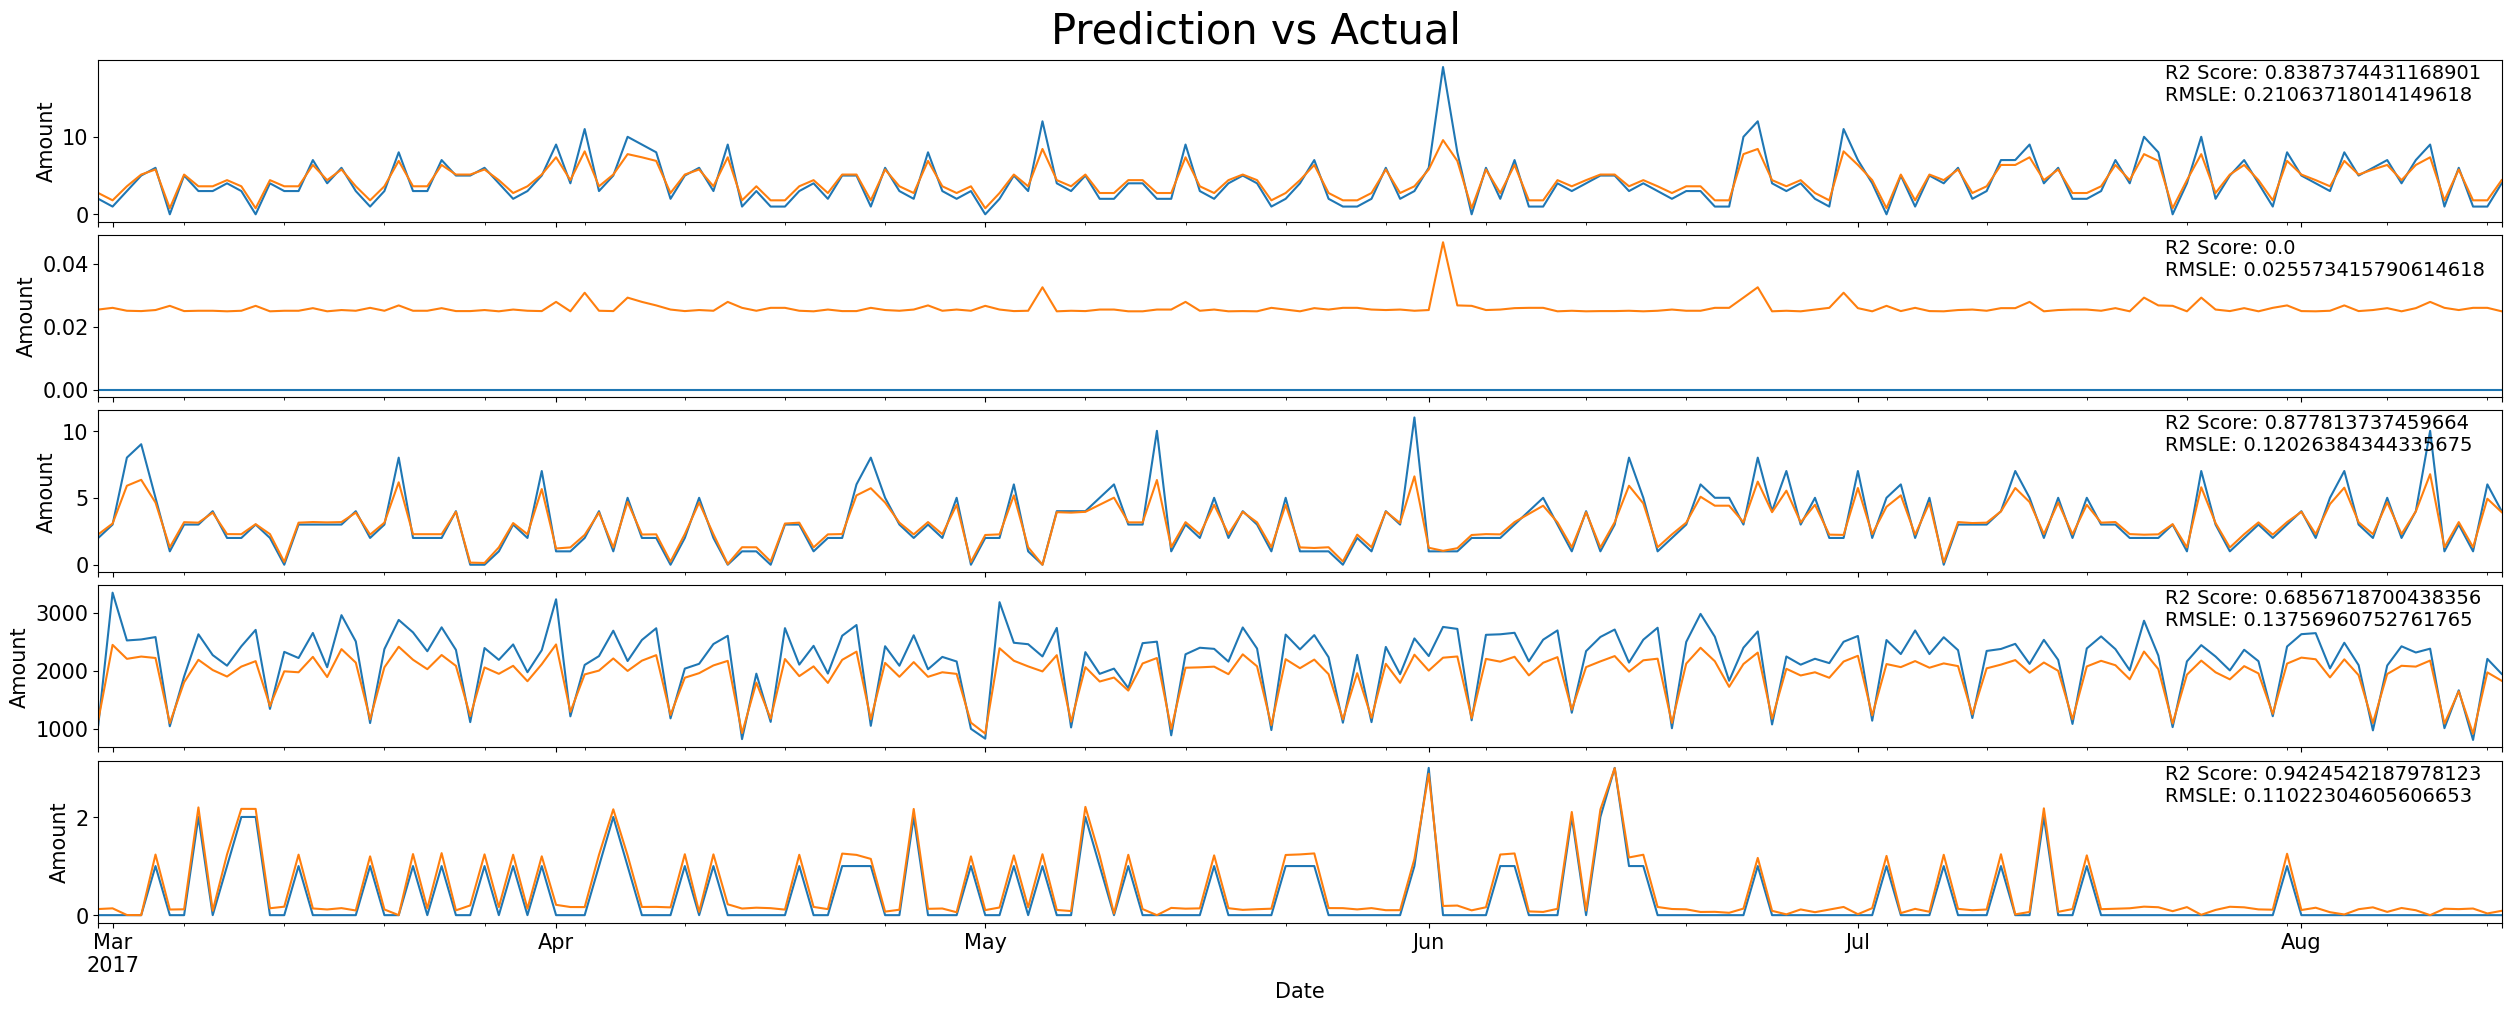

R2 Score                      -2.327459
Root Mean Squared Log Error    0.291510
dtype: float64


In [4]:
experiment(X_train, X_test, y_train, y_test, X_test_copy,
           X_test_index, model10, 'model10', '100 cell single layer LSTM', scaler=scaler)


## Normalization with Wide Layer

In [5]:
X = train
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index, scaler = data_prep(X, Y, scale=True)

In [6]:
def model11(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1], return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(1, activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 01m 43s]
val_loss: 0.03033853881061077

Best val_loss So Far: 0.006572268903255463
Total elapsed time: 00h 50m 18s
INFO:tensorflow:Oracle triggered exit


2023-04-21 11:39:27.063072: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.
2023-04-21 11:40:57.030074: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.
2023-04-21 11:42:27.169758: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.
2023-04-21 11:43:58.092985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.
2023-04-21 11:45:30.231484: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.


6/6 [==============================] - 5s 769ms/step


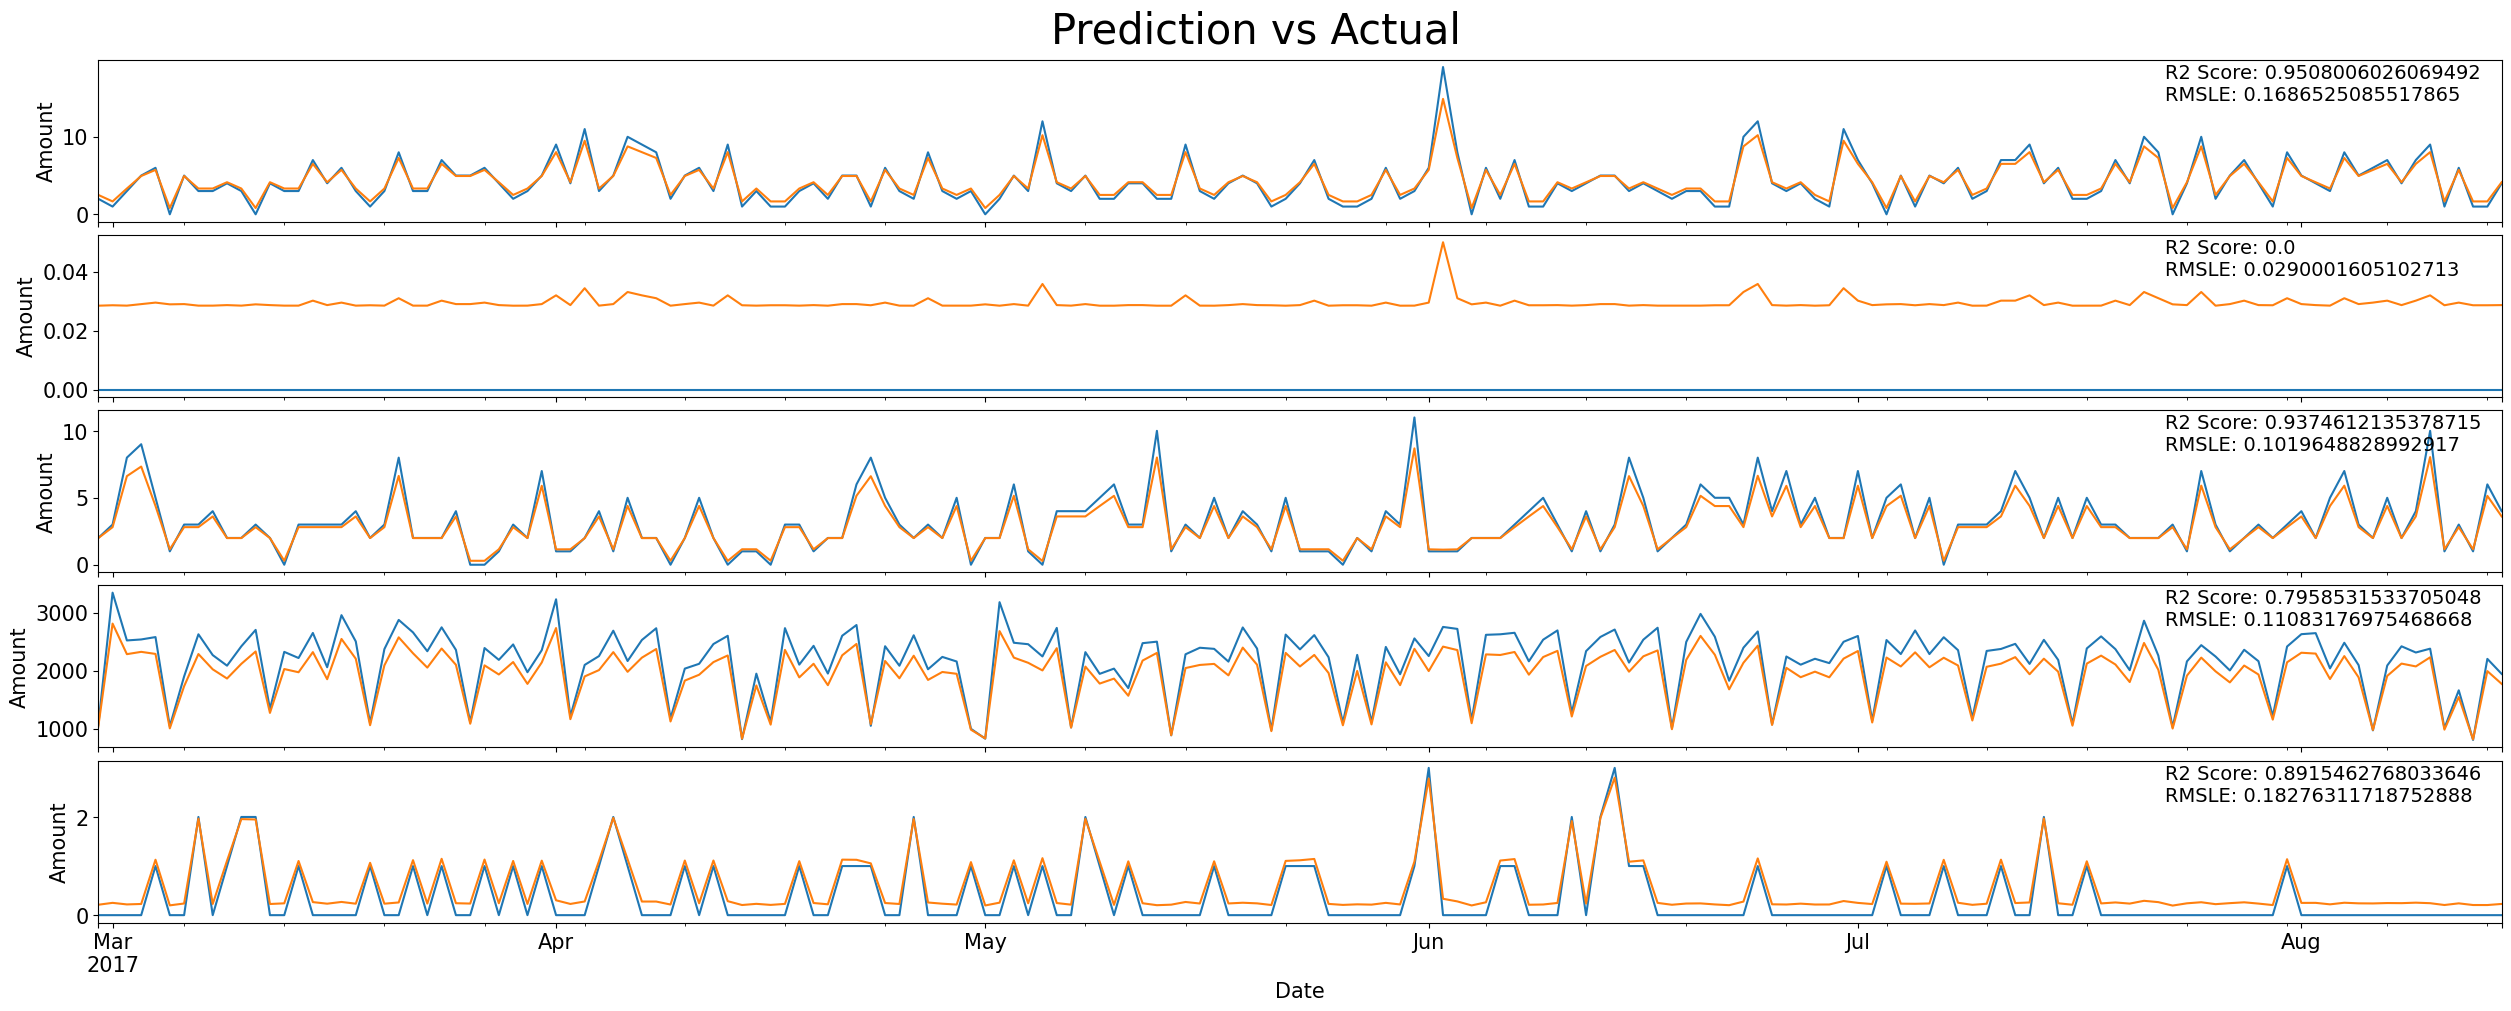

R2 Score                      -3.246779
Root Mean Squared Log Error    0.260680
dtype: float64


In [7]:
experiment(X_train, X_test, y_train, y_test, X_test_copy,
           X_test_index, model11, 'model11', 'Wide single layer LSTM', scaler=scaler)


## Normalization with Complex Network

In [9]:
low_var = [train.var().index[i] for i in range(len(train.var())) if train.var()[i]<395]
X = pd.concat([exog, train], axis=1)
Y = X.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test, X_test_copy, X_test_index, scaler = data_prep(X, Y, scale=True)


In [10]:
X1 = exog
X2 = train[low_var]
X3 = train.drop(low_var, axis=1)
X1_train, X1_test = train_test_split(X1, test_size=0.10, random_state=5, shuffle=False)
X2_train, X2_test = train_test_split(X2, test_size=0.10, random_state=5, shuffle=False)
X3_train, X3_test = train_test_split(X3, test_size=0.10, random_state=5, shuffle=False)
train_sets = [X1_train, X2_train, X3_train]
test_sets = [X1_test, X2_test, X3_test]
for j in [train_sets, test_sets]:
    for i in range(len(j)):
        j[i] = j[i].values.reshape(j[i].shape[0], j[i].shape[1], 1)

In [13]:
def model12(hp):
    input_1 = keras.layers.Input(shape=[train_sets[0].shape[1], train_sets[0].shape[2]])
    input_2 = keras.layers.Input(shape=[train_sets[1].shape[1], train_sets[1].shape[2]])
    input_3 = keras.layers.Input(shape=[train_sets[2].shape[1], train_sets[2].shape[2]])
    exog_hidden_1 = keras.layers.LSTM(26)(input_1)
    low_var_hidden_1 = keras.layers.LSTM(train_sets[1].shape[1]//3)(input_2)
    high_var_hidden_1 = keras.layers.LSTM(train_sets[2].shape[1]//3, return_sequences=True)(input_3)
    high_var_hidden_2 = keras.layers.LSTM(train_sets[2].shape[1]//3, return_sequences=True)(high_var_hidden_1)
    high_var_hidden_3 = keras.layers.LSTM(train_sets[2].shape[1]//3)(high_var_hidden_2)
    concat = keras.layers.concatenate([exog_hidden_1, low_var_hidden_1, high_var_hidden_3])
    output = keras.layers.Dense(X_train.shape[1], activation='relu')(concat)
    dummy_model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 00m 22s]
val_loss: 0.02675238996744156

Best val_loss So Far: 0.006362263113260269
Total elapsed time: 00h 10m 03s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 2s 103ms/step


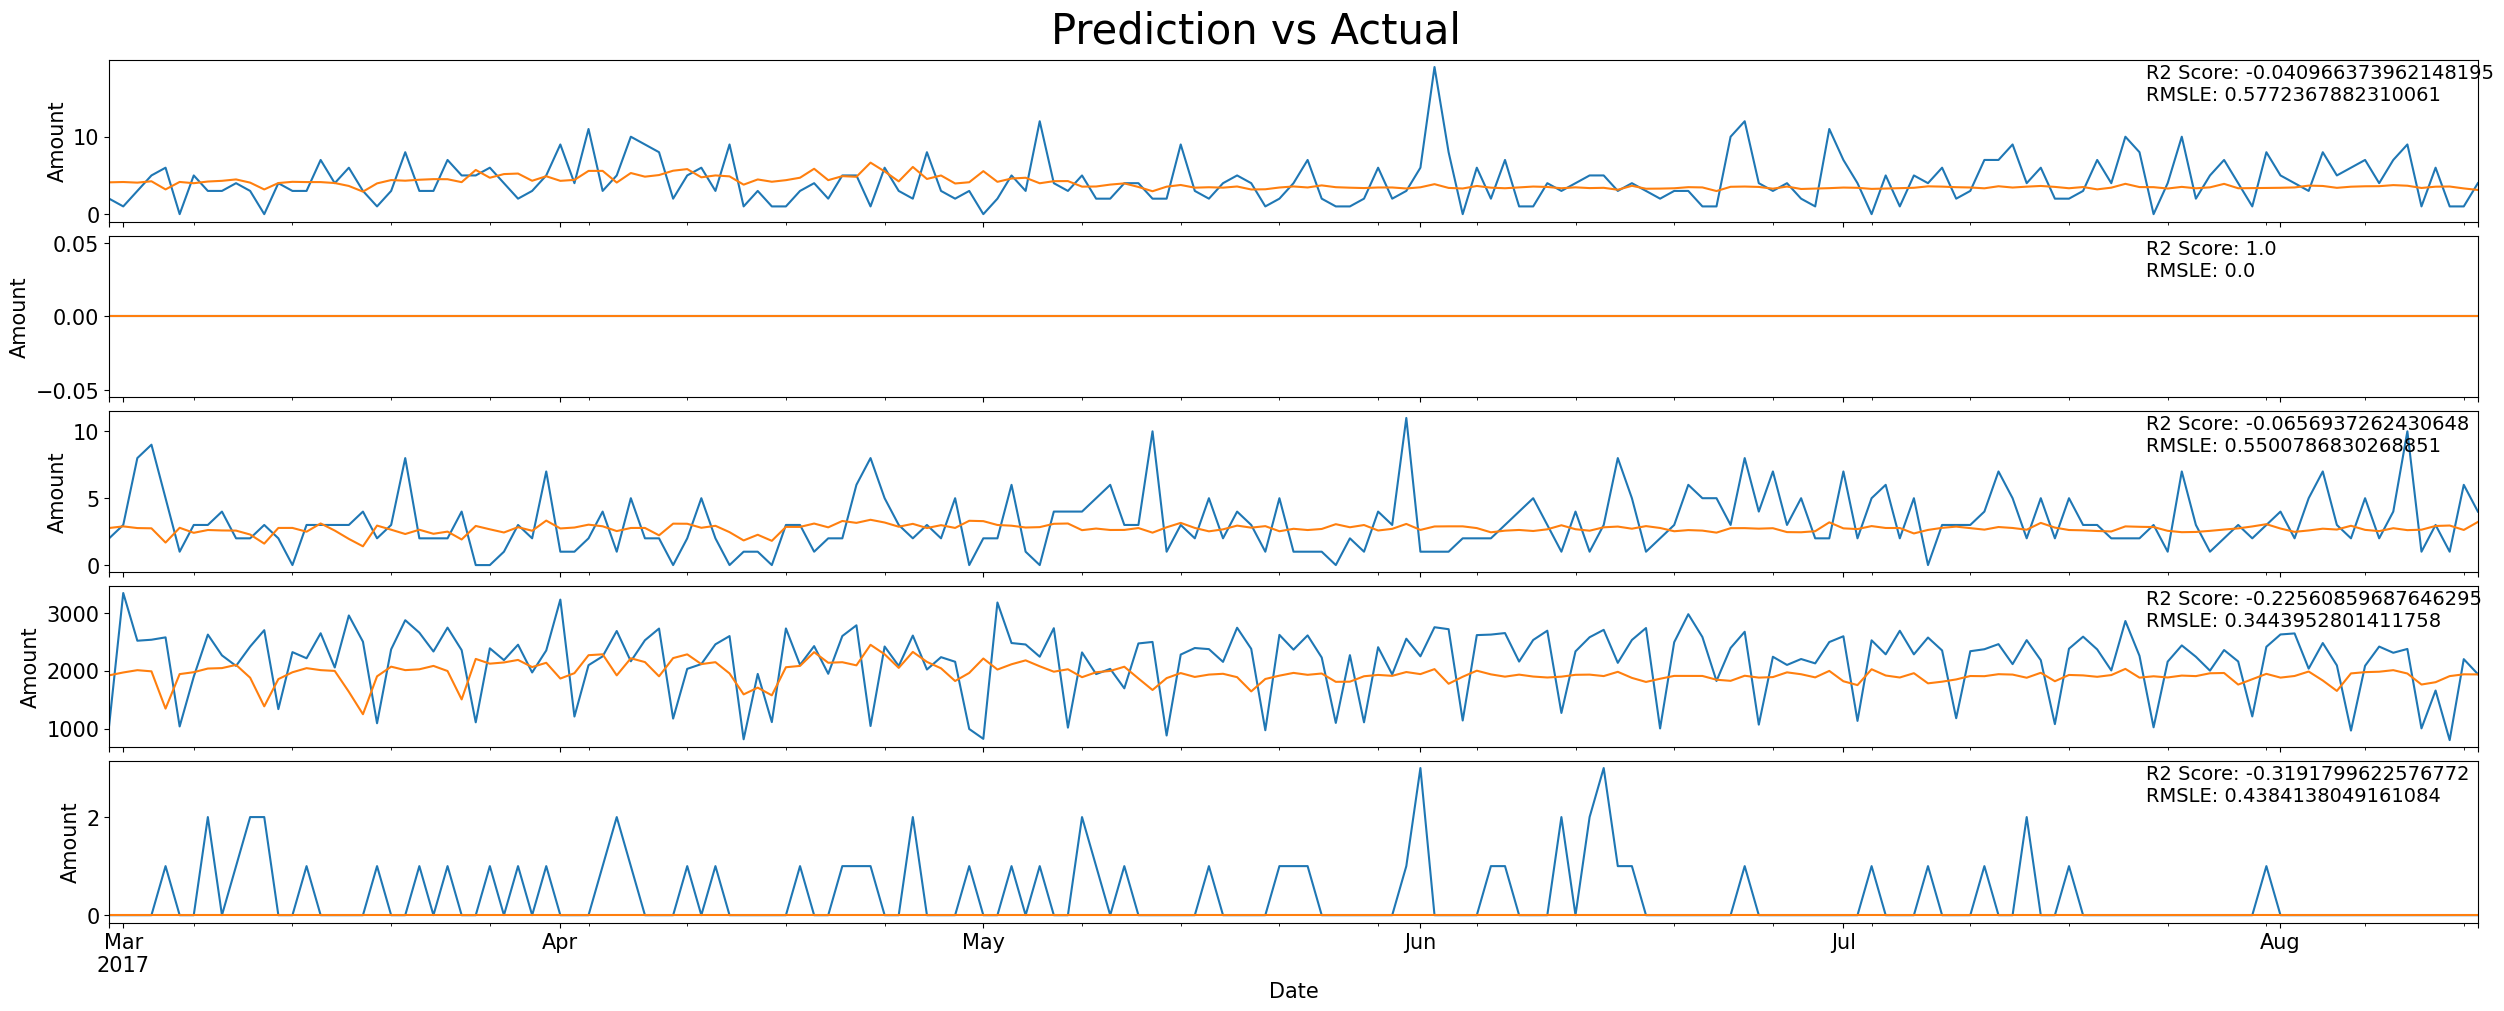

R2 Score                      -1.051456
Root Mean Squared Log Error    1.046115
dtype: float64


In [14]:
experiment(train_sets, test_sets, y_train, y_test, X_test_copy, X_test_index, model12, 'model12', 'complex LSTM with normalized data',scaler=scaler)

# Forecast

Best model is model11 with the wide network and data normalized.

In [2]:
dict = pickle.load(open('/home/nasibul/Desktop/e-commerce/Advanced ARIMA/Data/model11.pkl', 'rb'))
dict['params'].values

{'learning_rate': 0.001, 'optimizer': 'adam'}

The default settings were already the best ones. 

In [3]:
X = train
X_train, X_test = train_test_split(X, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
y_train = Y_forecast(X_train)
y_test = Y_forecast(X_test)
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], X.shape[1], 16)
y_test = y_test.values.reshape(y_test.shape[0], X.shape[1], 16)

In [4]:
final_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1], return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(16, activation='relu')
    ])
final_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())

2023-04-21 19:38:49.767027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 19:38:49.818551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 19:38:49.818709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 19:38:49.819114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
pred = predict(final_model, X_train, y_train, X_test, X_test_copy, X_test_index, forecast=True, scaler=scaler)

2023-04-21 19:38:55.354408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-04-21 19:38:56.422083: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7f3c018ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-21 19:38:56.422106: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-04-21 19:38:56.426090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-21 19:38:56.511706: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-04-21 19:40:22.527651: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.
2023-04-21 19:41:50.504644: W

6/6 [==============================] - 5s 789ms/step


In [6]:
submission = submit(pred)
submission.to_csv('3rd_LSTM_submission.csv', header=True, index=False)

        id        sales
0  3000888     3.387512
1  3000889     0.037056
2  3000890     3.628345
3  3000891  1875.669678
4  3000892     0.014948
5  3000893   317.467651
6  3000894    19.229088
7  3000895   634.689270
8  3000896   564.662109
9  3000897   105.718506
